# Estimating TESS rotation periods with CNNs

## Introduction

The NASA TESS mission conducts an all-sky survey searching for exoplanets that transit their host stars. To do so, it collects time series photometry called "light curves" for millions of stars across the sky. These light curves have many science uses besides exoplanets, including stellar rotation. As a star rotates, cool magnetic spots come into and out of view, causing periodic wiggles in the brighness measurements through time. We can therefore use light curves from TESS to infer stellar rotation periods, which are useful for studying stellar magnetism, structure, and ages. 

However, systematics associated with the telescope's special Earth-Moon orbit make it difficult to measure long (> 13 day) rotation periods from TESS light curves using conventional frequency analysis techniques. Machine learning methods, and in particular Convolutional Neural Networks (CNN) have been shown to circumvent some of the effects of systematics and estimate rotation periods from TESS light curves and their frequency transforms.

In this tutorial we will use a CNN to estimate stellar rotation periods from frequency transforms of TESS light curves. For our training set, we will use the simulations from the MAST High Level Science Product [SMARTS](https://archive.stsci.edu/hlsp/smarts). SMARTS combines physically realistic simulations of rotational light curves with real noise and systematics from TESS. This combination allows CNNs to learn the difference between rotation signals and systematics and estimate stellar rotation periods.

## Goals
The goal of this notebook is to use [SMARTS](https://archive.stsci.edu/hlsp/smarts) data to train a CNN to regress TESS rotation periods. We will

0. [Configure the training run](#0.configure-training-run),
1. [Prepare the training data](#1.prepare-training-data),
2. [Build the CNN](#2.build-the-cnn),
3. [Define training, validation, and evaluation functions](#3.define-training-validation-and-evaluation-functions),
4. [Train the CNN](#4.train-the-cnn-on-smarts-data), and
5. [Test the CNN performance](#5.test-the-cnn-performance).

The training examples are 2-dimensional arrays of wavelet transforms of TESS light curves. The wavelet transform concentrates the periodicity of the light curve, making it easier for a CNN to regress the period. CNNs take advantage of the image-like nature of a wavelet transform in the same way that CNNs are useful for image recognition and computer vision.

## Runtime

On the [TIKE](https://timeseries.science.stsci.edu) "Large" instance, this notebook takes just under 3 minutes to run from start to finish. The bulk of this time is spent downloading the training data. Once you've done that once, you can comment out the cell, and the notebook will be faster.

This notebook, including the CNN training, is configured to run on a single CPU.

## Installs and Imports
This notebook uses the following packages:
- `glob` for generating lists of training files
- `copy` for saving training weights
- `numpy` for array operations
- `matplotlib` for plotting
- `astropy` for reading FITS files
- `torch` for tensor and CNN operations

You can install the requirements by running `%pip install -r requirements.txt`.

In [1]:
from glob import glob  # for generating lists of input files
from copy import deepcopy  # for saving CNN weights

import numpy as np  # array operations
from astropy.io import fits  # FITS file operations
import matplotlib.pyplot as plt  # for plotting

# For tensor and CNN operations
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

## 0. Configure training run

Before we get started, we need to set some configuration parameters to know how much data to read in, and how many epochs to train for. Ideally, we want to run on the full training set (`max_n = 1_000_000`) for long enough that the loss plateaus (usually `num_epochs = 500`). But this for this simple demo, we will use a subset of training data and a shorter training time. We will train/validation/test using a 80%/10%/10% `split`, and we'll build a CNN with 3 convolution layers with filter depths increasing from 8, to 16, to 32 `filters`.

In [2]:
max_n = 10_000  # max 1_000_000
num_epochs = 20  # 100 is pretty good, typically ~300 to 500 to reach a plateau
split = [8, 1, 1]  # ratios for train/validation/test split
filters = [8, 16, 32]  # list of CNN layer filter depths

## 1. Prepare training data

The SMARTS training data are in the form of continuous Morlet wavelet transforms (CWTs) or wavelet power spectra (WPS). Rather than train on the light curve itself, the WPS provides a 2D representation of the frequency information present in the light curve. With frequency or period on the y-axis and time on the x-axis, the WPS illustrates which frequencies dominate the light curve at different times. Since it is effectively an image, we can take advantage of image recognition capabilities of CNNs.

For more information on CWTs, see
- [_A Practical Guide to Wavelet Analysis_, Torrence & Compo (1998)](https://ui.adsabs.harvard.edu/abs/1998BAMS...79...61T/abstract)
- [The `pycwt` Python package](https://github.com/regeirk/pycwt)

We will first download and extract the data, load it into a DataLoader, and then look at an example.

In [3]:
# Download and extract training data
# Comment this cell out if you've already downloaded and extracted the data once!
!curl -o hlsp_smarts_tess_ffi_all_tess_v1.0_cat.tar.gz https://archive.stsci.edu/hlsps/smarts/tess/hlsp_smarts_tess_ffi_all_tess_v1.0_cat.tar.gz
!tar -xvzf hlsp_smarts_tess_ffi_all_tess_v1.0_cat.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  3 1873M    3 61.8M    0     0  67.0M      0  0:00:27 --:--:--  0:00:27 67.0M

  6 1873M    6  114M    0     0  59.5M      0  0:00:31  0:00:01  0:00:30 59.5M

  6 1873M    6  128M    0     0  43.8M      0  0:00:42  0:00:02  0:00:40 43.8M

  7 1873M    7  134M    0     0  34.1M      0  0:00:54  0:00:03  0:00:51 34.1M

  7 1873M    7  140M    0     0  28.3M      0  0:01:06  0:00:04  0:01:02 28.3M

  7 1873M    7  145M    0     0  24.6M      0  0:01:16  0:00:05  0:01:11 16.7M

  7 1873M    7  149M    0     0  21.5M      0  0:01:26  0:00:06  0:01:20 7214k

  8 1873M    8  152M    0     0  19.1M      0  0:01:37  0:00:07  0:01:30 4897k

  8 1873M    8  154M    0     0  17.3M      0  0:01:47  0:00:08  0:01:39 4276k

  8 1873M    8  158M    0     0  15.9M      0  0:01:57  0:00:09  0:01:48 3791k

  8 1873M    8  163M    0     0  14.9M      0  0:02:05  0:00:10  0:01:55 3609k

  8 1873M    8  167M    0     0  14.0M      0  0:02:13  0:00:11  0:02:02 3568k

  9 1873M    9  170M    0     0  13.1M      0  0:02:22  0:00:12  0:02:10 3695k

  9 1873M    9  173M    0     0  12.4M      0  0:02:30  0:00:13  0:02:17 3793k

  9 1873M    9  176M    0     0  11.8M      0  0:02:38  0:00:14  0:02:24 3745k

  9 1873M    9  180M    0     0  11.3M      0  0:02:45  0:00:15  0:02:30 3558k

  9 1873M    9  184M    0     0  10.8M      0  0:02:52  0:00:16  0:02:36 3482k

 10 1873M   10  187M    0     0  10.4M      0  0:02:59  0:00:17  0:02:42 3565k

 10 1873M   10  191M    0     0  10.1M      0  0:03:05  0:00:18  0:02:47 3709k

 10 1873M   10  194M    0     0   9.7M      0  0:03:11  0:00:19  0:02:52 3672k

 10 1873M   10  197M    0     0  9670k      0  0:03:18  0:00:20  0:02:58 3474k

 10 1873M   10  200M    0     0  9346k      0  0:03:25  0:00:21  0:03:04 3293k

 10 1873M   10  202M    0     0  9062k      0  0:03:31  0:00:22  0:03:09 3143k

 10 1873M   10  206M    0     0  8813k      0  0:03:37  0:00:23  0:03:14 2956k

 11 1873M   11  210M    0     0  8637k      0  0:03:42  0:00:24  0:03:18 3160k

 11 1873M   11  213M    0     0  8434k      0  0:03:47  0:00:25  0:03:22 3253k

 11 1873M   11  217M    0     0  8254k      0  0:03:52  0:00:26  0:03:26 3468k

 11 1873M   11  219M    0     0  8048k      0  0:03:58  0:00:27  0:03:31 3388k

 11 1873M   11  222M    0     0  7861k      0  0:04:04  0:00:28  0:03:36 3289k

 12 1873M   12  225M    0     0  7723k      0  0:04:08  0:00:29  0:03:39 3166k

 12 1873M   12  230M    0     0  7635k      0  0:04:11  0:00:30  0:03:41 3496k

 12 1873M   12  234M    0     0  7505k      0  0:04:15  0:00:31  0:03:44 3486k

 12 1873M   12  236M    0     0  7350k      0  0:04:21  0:00:32  0:03:49 3449k

 12 1873M   12  238M    0     0  7206k      0  0:04:26  0:00:33  0:03:53 3416k

 12 1873M   12  240M    0     0  7064k      0  0:04:31  0:00:34  0:03:57 3124k

 13 1873M   13  244M    0     0  6957k      0  0:04:35  0:00:35  0:04:00 2778k

 13 1873M   13  248M    0     0  6880k      0  0:04:38  0:00:36  0:04:02 2882k

 13 1873M   13  250M    0     0  6774k      0  0:04:43  0:00:37  0:04:06 2988k

 13 1873M   13  253M    0     0  6653k      0  0:04:48  0:00:38  0:04:10 2918k

 13 1873M   13  255M    0     0  6547k      0  0:04:53  0:00:39  0:04:14 2931k

 13 1873M   13  258M    0     0  6465k      0  0:04:56  0:00:40  0:04:16 2922k

 14 1873M   14  262M    0     0  6419k      0  0:04:58  0:00:41  0:04:17 3004k

 14 1873M   14  267M    0     0  6387k      0  0:05:00  0:00:42  0:04:18 3447k

 14 1873M   14  272M    0     0  6345k      0  0:05:02  0:00:43  0:04:19 3942k

 14 1873M   14  275M    0     0  6276k      0  0:05:05  0:00:44  0:04:21 4116k

 14 1873M   14  278M    0     0  6208k      0  0:05:09  0:00:45  0:04:24 4093k

 15 1873M   15  281M    0     0  6152k      0  0:05:11  0:00:46  0:04:25 3913k

 15 1873M   15  285M    0     0  6106k      0  0:05:14  0:00:47  0:04:27 3696k

 15 1873M   15  289M    0     0  6056k      0  0:05:16  0:00:48  0:04:28 3516k

 15 1873M   15  292M    0     0  6001k      0  0:05:19  0:00:49  0:04:30 3529k

 15 1873M   15  295M    0     0  5936k      0  0:05:23  0:00:50  0:04:33 3445k

 15 1873M   15  298M    0     0  5887k      0  0:05:25  0:00:51  0:04:34 3407k

 16 1873M   16  301M    0     0  5829k      0  0:05:29  0:00:52  0:04:37 3176k

 16 1873M   16  303M    0     0  5759k      0  0:05:33  0:00:53  0:04:40 2855k

 16 1873M   16  305M    0     0  5699k      0  0:05:36  0:00:54  0:04:42 2686k

 16 1873M   16  307M    0     0  5634k      0  0:05:40  0:00:55  0:04:45 2555k

 16 1873M   16  309M    0     0  5570k      0  0:05:44  0:00:56  0:04:48 2268k

 16 1873M   16  311M    0     0  5500k      0  0:05:48  0:00:57  0:04:51 2019k

 16 1873M   16  313M    0     0  5449k      0  0:05:52  0:00:58  0:04:54 2105k

 16 1873M   16  316M    0     0  5403k      0  0:05:55  0:00:59  0:04:56 2147k

 17 1873M   17  319M    0     0  5370k      0  0:05:57  0:01:00  0:04:57 2415k

 17 1873M   17  323M    0     0  5345k      0  0:05:58  0:01:01  0:04:57 2800k

 17 1873M   17  327M    0     0  5330k      0  0:05:59  0:01:02  0:04:57 3363k

 17 1873M   17  330M    0     0  5301k      0  0:06:01  0:01:03  0:04:58 3558k

 17 1873M   17  333M    0     0  5263k      0  0:06:04  0:01:04  0:05:00 3592k

 17 1873M   17  336M    0     0  5226k      0  0:06:07  0:01:05  0:05:02 3468k

 18 1873M   18  339M    0     0  5193k      0  0:06:09  0:01:06  0:05:03 3310k

 18 1873M   18  341M    0     0  5149k      0  0:06:12  0:01:07  0:05:05 2878k

 18 1873M   18  344M    0     0  5114k      0  0:06:15  0:01:08  0:05:07 2728k

 18 1873M   18  346M    0     0  5079k      0  0:06:17  0:01:09  0:05:08 2680k

 18 1873M   18  349M    0     0  5052k      0  0:06:19  0:01:10  0:05:09 2766k

 18 1873M   18  351M    0     0  5009k      0  0:06:23  0:01:11  0:05:12 2539k

 18 1873M   18  354M    0     0  4973k      0  0:06:25  0:01:12  0:05:13 2579k

 19 1873M   19  357M    0     0  4946k      0  0:06:27  0:01:13  0:05:14 2622k

 19 1873M   19  358M    0     0  4904k      0  0:06:31  0:01:14  0:05:17 2461k

 19 1873M   19  360M    0     0  4866k      0  0:06:34  0:01:15  0:05:19 2223k

 19 1873M   19  363M    0     0  4835k      0  0:06:36  0:01:16  0:05:20 2322k

 19 1873M   19  365M    0     0  4808k      0  0:06:39  0:01:17  0:05:22 2403k

 19 1873M   19  368M    0     0  4779k      0  0:06:41  0:01:18  0:05:23 2318k

 19 1873M   19  370M    0     0  4747k      0  0:06:44  0:01:19  0:05:25 2392k

 19 1873M   19  373M    0     0  4726k      0  0:06:45  0:01:20  0:05:25 2607k

 20 1873M   20  375M    0     0  4695k      0  0:06:48  0:01:21  0:05:27 2539k

 20 1873M   20  377M    0     0  4658k      0  0:06:51  0:01:22  0:05:29 2304k

 20 1873M   20  379M    0     0  4629k      0  0:06:54  0:01:23  0:05:31 2250k

 20 1873M   20  381M    0     0  4601k      0  0:06:57  0:01:24  0:05:33 2266k

 20 1873M   20  384M    0     0  4582k      0  0:06:58  0:01:25  0:05:33 2257k

 20 1873M   20  387M    0     0  4564k      0  0:07:00  0:01:26  0:05:34 2436k

 20 1873M   20  389M    0     0  4540k      0  0:07:02  0:01:27  0:05:35 2590k

 20 1873M   20  392M    0     0  4515k      0  0:07:04  0:01:28  0:05:36 2604k

 21 1873M   21  394M    0     0  4491k      0  0:07:07  0:01:29  0:05:38 2633k

 21 1873M   21  397M    0     0  4476k      0  0:07:08  0:01:30  0:05:38 2635k

 21 1873M   21  399M    0     0  4450k      0  0:07:11  0:01:31  0:05:40 2456k

 21 1873M   21  401M    0     0  4419k      0  0:07:14  0:01:32  0:05:42 2302k

 21 1873M   21  403M    0     0  4397k      0  0:07:16  0:01:33  0:05:43 2297k

 21 1873M   21  406M    0     0  4380k      0  0:07:18  0:01:34  0:05:44 2371k

 21 1873M   21  409M    0     0  4369k      0  0:07:19  0:01:35  0:05:44 2429k

 21 1873M   21  411M    0     0  4348k      0  0:07:21  0:01:36  0:05:45 2479k

 22 1873M   22  413M    0     0  4322k      0  0:07:23  0:01:37  0:05:46 2516k

 22 1873M   22  415M    0     0  4296k      0  0:07:26  0:01:38  0:05:48 2392k

 22 1873M   22  417M    0     0  4274k      0  0:07:28  0:01:39  0:05:49 2267k

 22 1873M   22  420M    0     0  4262k      0  0:07:30  0:01:40  0:05:50 2215k

 22 1873M   22  423M    0     0  4253k      0  0:07:31  0:01:41  0:05:50 2416k

 22 1873M   22  425M    0     0  4232k      0  0:07:33  0:01:42  0:05:51 2471k

 22 1873M   22  427M    0     0  4213k      0  0:07:35  0:01:43  0:05:52 2580k

 22 1873M   22  429M    0     0  4187k      0  0:07:38  0:01:44  0:05:54 2446k

 23 1873M   23  431M    0     0  4166k      0  0:07:40  0:01:45  0:05:55 2226k

 23 1873M   23  433M    0     0  4149k      0  0:07:42  0:01:46  0:05:56 2025k

 23 1873M   23  436M    0     0  4140k      0  0:07:43  0:01:47  0:05:56 2250k

 23 1873M   23  439M    0     0  4136k      0  0:07:43  0:01:48  0:05:55 2526k

 23 1873M   23  444M    0     0  4136k      0  0:07:43  0:01:49  0:05:54 3072k

 23 1873M   23  447M    0     0  4126k      0  0:07:45  0:01:50  0:05:55 3285k

 24 1873M   24  450M    0     0  4120k      0  0:07:45  0:01:51  0:05:54 3495k

 24 1873M   24  454M    0     0  4124k      0  0:07:45  0:01:52  0:05:53 3775k

 24 1873M   24  458M    0     0  4120k      0  0:07:45  0:01:53  0:05:52 3772k

 24 1873M   24  461M    0     0  4110k      0  0:07:46  0:01:54  0:05:52 3532k

 24 1873M   24  465M    0     0  4109k      0  0:07:46  0:01:55  0:05:51 3738k

 25 1873M   25  469M    0     0  4109k      0  0:07:46  0:01:56  0:05:50 3860k

 25 1873M   25  473M    0     0  4108k      0  0:07:47  0:01:57  0:05:50 3750k

 25 1873M   25  478M    0     0  4116k      0  0:07:46  0:01:58  0:05:48 4028k

 25 1873M   25  483M    0     0  4125k      0  0:07:45  0:01:59  0:05:46 4478k

 25 1873M   25  486M    0     0  4122k      0  0:07:45  0:02:00  0:05:45 4423k

 26 1873M   26  489M    0     0  4112k      0  0:07:46  0:02:01  0:05:45 4179k

 26 1873M   26  493M    0     0  4110k      0  0:07:46  0:02:02  0:05:44 4158k

 26 1873M   26  498M    0     0  4116k      0  0:07:46  0:02:03  0:05:43 4134k

 26 1873M   26  502M    0     0  4121k      0  0:07:45  0:02:04  0:05:41 4015k

 27 1873M   27  507M    0     0  4124k      0  0:07:45  0:02:05  0:05:40 4163k

 27 1873M   27  511M    0     0  4122k      0  0:07:45  0:02:06  0:05:39 4386k

 27 1873M   27  516M    0     0  4131k      0  0:07:44  0:02:07  0:05:37 4652k

 27 1873M   27  522M    0     0  4150k      0  0:07:42  0:02:08  0:05:34 4985k

 28 1873M   28  530M    0     0  4180k      0  0:07:39  0:02:09  0:05:30 5650k

 28 1873M   28  539M    0     0  4216k      0  0:07:35  0:02:10  0:05:25 6533k

 29 1873M   29  546M    0     0  4240k      0  0:07:32  0:02:11  0:05:21 7222k

 29 1873M   29  552M    0     0  4257k      0  0:07:30  0:02:12  0:05:18 7477k

 29 1873M   29  559M    0     0  4277k      0  0:07:28  0:02:13  0:05:15 7559k

 30 1873M   30  564M    0     0  4282k      0  0:07:28  0:02:14  0:05:14 6939k

 30 1873M   30  570M    0     0  4295k      0  0:07:26  0:02:15  0:05:11 6373k

 30 1873M   30  576M    0     0  4307k      0  0:07:25  0:02:16  0:05:09 6079k

 30 1873M   30  580M    0     0  4311k      0  0:07:25  0:02:17  0:05:08 5734k

 31 1873M   31  586M    0     0  4322k      0  0:07:23  0:02:18  0:05:05 5524k

 31 1873M   31  590

M    0     0  4324k      0  0:07:23  0:02:19  0:05:04 5475k

 31 1873M   31  595M    0     0  4328k      0  0:07:23  0:02:20  0:05:03 5211k

 32 1873M   32  600M    0     0  4331k      0  0:07:23  0:02:21  0:05:02 4974k

 32 1873M   32  605M    0     0  4335k      0  0:07:22  0:02:22  0:05:00 5006k

 32 1873M   32  610M    0     0  4340k      0  0:07:22  0:02:23  0:04:59 4834k

 32 1873M   32  616M    0     0  4353k      0  0:07:20  0:02:24  0:04:56 5152k

 33 1873M   33  623M    0     0  4375k      0  0:07:18  0:02:25  0:04:53 5702k

 33 1873M   33  629M    0     0  4388k      0  0:07:17  0:02:26  0:04:51 6012k

 33 1873M   33  634M    0     0  4394k      0  0:07:16  0:02:27  0:04:49 6090k

 34 1873M   34  638M    0     0  4386k      0  0:07:17  0:02:28  0:04:49 5714k

 34 1873M   34  640M    0     0  4377k      0  0:07:18  0:02:29  0:04:49 5058k

 34 1873M   34  643M    0     0  4364k      0  0:07:19  0:02:30  0:04:49 4037k

 34 1873M   34  646M    0     0  4356k      0  0:07:20  0:02:31  0:04:49 3436k

 34 1873M   34  650M    0     0  4358k      0  0:07:20  0:02:32  0:04:48 3273k

 35 1873M   35  655M    0     0  4363k      0  0:07:19  0:02:33  0:04:46 3686k

 35 1873M   35  659M    0     0  4357k      0  0:07:20  0:02:34  0:04:46 3775k

 35 1873M   35  662M    0     0  4352k      0  0:07:20  0:02:35  0:04:45 4016k

 35 1873M   35  666M    0     0  4350k      0  0:07:21  0:02:36  0:04:45 4146k

 35 1873M   35  670M    0     0  4348k      0  0:07:21  0:02:37  0:04:44 4051k

 35 1873M   35  674M    0     0  4343k      0  0:07:21  0:02:38  0:04:43 3720k

 36 1873M   36  677M    0     0  4338k      0  0:07:22  0:02:39  0:04:43 3743k

 36 1873M   36  681M    0     0  4337k      0  0:07:22  0:02:40  0:04:42 3856k

 36 1873M   36  685M    0     0  4332k      0  0:07:22  0:02:41  0:04:41 3767k

 36 1873M   36  688M    0     0  4330k      0  0:07:23  0:02:42  0:04:41 3750k

 36 1873M   36  691M    0     0  4317k      0  0:07:24  0:02:43  0:04:41 3495k

 37 1873M   37  693M    0     0  4305k      0  0:07:25  0:02:44  0:04:41 3246k

 37 1873M   37  696M    0     0  4296k      0  0:07:26  0:02:45  0:04:41 2972k

 37 1873M   37  700M    0     0  4294k      0  0:07:26  0:02:46  0:04:40 3087k

 37 1873M   37  703M    0     0  4292k      0  0:07:27  0:02:47  0:04:40 3062k

 37 1873M   37  708M    0     0  4297k      0  0:07:26  0:02:48  0:04:38 3619k

 38 1873M   38  714M    0     0  4308k      0  0:07:25  0:02:49  0:04:36 4415k

 38 1873M   38  719M    0     0  4312k      0  0:07:24  0:02:50  0:04:34 4846k

 38 1873M   38  724M    0     0  4316k      0  0:07:24  0:02:51  0:04:33 5027k

 38 1873M   38  730M    0     0  4327k      0  0:07:23  0:02:52  0:04:31 5516k

 39 1873M   39  735M    0     0  4330k      0  0:07:23  0:02:53  0:04:30 5465k

 39 1873M   39  739M    0     0  4329k      0  0:07:23  0:02:54  0:04:29 5051k

 39 1873M   39  743M    0     0  4329k      0  0:07:23  0:02:55  0:04:28 4901k

 39 1873M   39  747M    0     0  4326k      0  0:07:23  0:02:56  0:04:27 4679k

 40 1873M   40  751M    0     0  4324k      0  0:07:23  0:02:57  0:04:26 4230k

 40 1873M   40  755M    0     0  4322k      0  0:07:23  0:02:58  0:04:25 4053k

 40 1873M   40  758M    0     0  4314k      0  0:07:24  0:02:59  0:04:25 3779k

 40 1873M   40  761M    0     0  4308k      0  0:07:25  0:03:00  0:04:25 3566k

 40 1873M   40  764M    0     0  4303k      0  0:07:25  0:03:01  0:04:24 3506k

 40 1873M   40  767M    0     0  4298k      0  0:07:26  0:03:02  0:04:24 3356k

 41 1873M   41  770M    0     0  4292k      0  0:07:27  0:03:03  0:04:24 3203k

 41 1873M   41  773M    0     0  4282k      0  0:07:28  0:03:04  0:04:24 3146k

 41 1873M   41  776M    0     0  4278k      0  0:07:28  0:03:05  0:04:23 3207k

 41 1873M   41  780M    0     0  4273k      0  0:07:28  0:03:06  0:04:22 3177k

 41 1873M   41  784M    0     0  4274k      0  0:07:28  0:03:07  0:04:21 3394k

 41 1873M   41  786M    0     0  4265k      0  0:07:29  0:03:08  0:04:21 3260k

 42 1873M   42  790M    0     0  4260k      0  0:07:30  0:03:09  0:04:21 3420k

 42 1873M   42  794M    0     0  4261k      0  0:07:30  0:03:10  0:04:20 3646k

 42 1873M   42  799M    0     0  4263k      0  0:07:30  0:03:11  0:04:19 3867k

 42 1873M   42  802M    0     0  4257k      0  0:07:30  0:03:12  0:04:18 3631k

 42 1873M   42  805M    0     0  4252k      0  0:07:31  0:03:13  0:04:18 3772k

 43 1873M   43  808M    0     0  4248k      0  0:07:31  0:03:14  0:04:17 3787k

 43 1873M   43  812M    0     0  4246k      0  0:07:31  0:03:15  0:04:16 3646k

 43 1873M   43  816M    0     0  4248k      0  0:07:31  0:03:16  0:04:15 3668k

 43 1873M   43  821M    0     0  4250k      0  0:07:31  0:03:17  0:04:14 3952k

 44 1873M   44  827M    0     0  4258k      0  0:07:30  0:03:18  0:04:12 4499k

 44 1873M   44  833M    0     0  4271k      0  0:07:29  0:03:19  0:04:10 5180k

 44 1873M   44  839M    0     0  4279k      0  0:07:28  0:03:20  0:04:08 5567k

 45 1873M   45  845M    0     0  4286k      0  0:07:27  0:03:21  0:04:06 5792k

 45 1873M   45  851M    0     0  4295k      0  0:07:26  0:03:22  0:04:04 6096k

 45 1873M   45  856M    0     0  4300k      0  0:07:26  0:03:23  0:04:03 5975k

 45 1873M   45  861M    0     0  4303k      0  0:07:25  0:03:24  0:04:01 5581k

 46 1873M   46  864M    0     0  4300k      0  0:07:26  0:03:25  0:04:01 5176k

 46 1873M   46  868M    0     0  4299k      0  0:07:26  0:03:26  0:04:00 4838k

 46 1873M   46  874M    0     0  4305k      0  0:07:25  0:03:27  0:03:58 4704k

 46 1873M   46  880M    0     0  4315k      0  0:07:24  0:03:28  0:03:56 4931k

 47 1873M   47  887M    0     0  4330k      0  0:07:23  0:03:29  0:03:54 5438k

 47 1873M   47  893M    0     0  4335k      0  0:07:22  0:03:30  0:03:52 5753k

 47 1873M   47  898M    0   

  0  4343k      0  0:07:21  0:03:31  0:03:50 6134k

 48 1873M   48  904M    0     0  4348k      0  0:07:21  0:03:32  0:03:49 6130k

 48 1873M   48  908M    0     0  4350k      0  0:07:21  0:03:33  0:03:48 5809k

 48 1873M   48  913M    0     0  4351k      0  0:07:20  0:03:34  0:03:46 5239k

 49 1873M   49  918M    0     0  4357k      0  0:07:20  0:03:35  0:03:45 5270k

 49 1873M   49  925M    0     0  4367k      0  0:07:19  0:03:36  0:03:43 5410k

 49 1873M   49  933M    0     0  4384k      0  0:07:17  0:03:37  0:03:40 5945k

 50 1873M   50  941M    0     0  4401k      0  0:07:15  0:03:38  0:03:37 6585k

 50 1873M   50  946M    0     0  4407k      0  0:07:15  0:03:39  0:03:36 6801k

 50 1873M   50  950M    0     0

  4405k      0  0:07:15  0:03:40  0:03:35 6514k

 50 1873M   50  955M    0     0  4407k      0  0:07:15  0:03:41  0:03:34 6155k

 51 1873M   51  959M    0     0  4408k      0  0:07:15  0:03:42  0:03:33 5421k

 51 1873M   51  965M    0     0  4413k      0  0:07:14  0:03:43  0:03:31 4942k

 51 1873M   51  970M    0     0  4417k      0  0:07:14  0:03:44  0:03:30 4885k

 52 1873M   52  975M    0     0  4421k      0  0:07:14  0:03:45  0:03:29 5088k

 52 1873M   52  980M    0     0  4426k      0  0:07:13  0:03:46  0:03:27 5230k

 52 1873M   52  985M    0     0  4429k      0  0:07:13  0:03:47  0:03:26 5372k

 52 1873M   52  990M    0     0  4431k      0  0:07:13  0:03:48  0:03:25 5212k

 53 1873M   53  996M    0     0  4436k      0  0:07:12  0:03:49  0:03:23 5296k

 53 1873M   53 1001M    0     0  4439k      0  0:07:12  0:03:50  0:03:22 5263k

 53 1873M   53 1006M    0     0  4445k      0  0:07:11  0:03:51  0:03:20 5323k

 53 1873M   53 1010M    0     0  4443k      0  0:07:11  0:03:52  0:03:19 5104k

 54 1873M   54 1014M    0     0  4441k      0  0:07:12  0:03:53  0:03:19 4894k

 54 1873M   54 1019M    0     0  4443k      0  0:07:11  0:03:54  0:03:17 4750k

 54 1873M   54 1023M    0     0  4440k      0  0:07:12  0:03:55  0:03:17 4509k

 54 1873M   54 1027M    0     0  4441k      0  0:07:12  0:03:56  0:03:16 4239k

 55 1873M   55 1033M    0     0  4447k      0  0:07:11  0:03:57  0:03:14 4611k

 55 1873M   55 1040M    0     0  4458k      0  0:07:10  0:03:58  0:03:12 5274k

 55 1873M   55 1045M    0     0  4462k      0  0:07:09  0:03:59  0:03:10 5370k

 56 1873M   56 1050M    0     0  4463k      0  0:07:09  0:04:00  0:03:09 5541k

 56 1873M   56 1054M    0     0  4465k      0  0:07:09  0:04:01  0:03:08 5627k

 56 1873M   56 1061M    0     0  4472k      0  0:07:09  0:04:02  0:03:07 5677k

 57 1873M   57 1068M    0     0  4484k      0  0:07:07  0:04:03  0:03:04 5705k

 57 1873M   57 1076M    0     0  4501k      0  0:07:06  0:04:04  0:03:02 6371k

 57 1873M   57 1084M    0     0  4514k      0  0:07:05  0:04:05  0:03:00 6946k

 58 1873M   58 1092M    0     0  4530k      0  0:07:03  0:04:06  0:02:57 7658k

 58 1873M   58 1097M    0     0  4532k      0  0:07:03  0:04:07  0:02:56 7453k

 58 1873M   58 1102M    0     0  4536k      0  0:07:03  0:04:08  0:02:55 7072k

 59 1873M   59 1108M    0     0  4542k      0  0:07:02  0:04:09  0:02:53 6513k

 59 1873M   59 1113M    0     0  4545k      0  0:07:02  0:04:10  0:02:52 6065k

 59 1873M   59 1119M    0     0  4549k      0  0:07:01  0:04:11  0:02:50 5506k

 60 1873M   60 1125M    0     0  4554k      0  0:07:01  0:04:12  0:02:49 5656k

 60 1873M   60 1131M    0     0  4561k      0  0:07:00  0:04:13  0:02:47 5792k

 60 1873M   60 1136M    0     0  4567k      0  0:07:00  0:04:14  0:02:46 5819k

 60 1873M   60 1142M    0     0  4569k      0  0:06:59  0:04:15  0:02:44 5795k

 61 1873M   61 1146M    0     0  4567k      0  0:07:00  0:04:16  0:02:44 5466k

 61 1873M   61 1150M    0     0  4567k      0  0:07:00  0:04:17  0:02:43 5223k

 61 1873M   61 1156M    0     0  4573k      0  0:06:59  0:04:18  0:02:41 5184k

 62 1873M   62 1163M    0     0  4584k      0  0:06:58  0:04:19  0:02:39 5446k

 62 1873M   62 1171M    0     0  4599k      0  0:06:57  0:04:20  0:02:37 6136k

 63 1873M   63 1181M    0     0  4619k      0  0:06:55  0:04:21  0:02:34 7284k

 63 1873M   63 1190M    0     0  4635k      0  0:06:53  0:04:22  0:02:31 8109k

 64 1873M   64 1199M    0     0  4654k      0  0:06:52  0:04:23  0:02:29 8893k

 64 1873M   64 1210M    0     0  4677k      0  0:06:50  0:04:24  0:02:26 9541k

 65 1873M   65 1221M    0     0  4703k      0  0:06:47  0:04:25  0:02:22  9.9M

 65 1873M   65 1231M    0     0  4724k      0  0:06:46  0:04:26  0:02:20  9.9M

 66 1873M   66 1242M    0     0  4748k      0  0:06:44  0:04:27  0:02:17 10.4M

 66 1873M   66 1249M    0     0  4755k      0  0:06:43  0:04:28  0:02:15  9.8M

 67 1873M   67 1255M    0     0  4763k      0  0:06:42  0:04:29  0:02:13 9332k

 67 1873M   67 1260M    0     0  4763k      0  0:06:42  0:04:30  0:02:12 7945k

 67 1873M   67 1263M    0     0  4758k      0  0:06:43  0:04:31  0:02:12 6590k

 67 1873M   67 1268M    0     0  4757k      0  0:06:43  0:04:32  0:02:11 5238k

 67 1873M   67 1274M    0     0  4762k      0  0:06:42  0:04:33  0:02:09 5126k

 68 1873M   68 1280M    0 

    0  4771k      0  0:06:42  0:04:34  0:02:08 5161k

 68 1873M   68 1286

M    0     0  4774k      0  0:06:41  0:04:35  0:02:06 5339k

 68 1873M   68 1290M    0     0  4771k      0  0:06:42  0:04:36  0:02:06 5506k

 69 1873M   69 1294M    0     0  4768k      0  0:06:42  0:04:37  0:02:05 5369k

 69 1873M   69 1298M    0     0  4766k      0  0:06:42  0:04:38  0:02:04 5004k

 69 1873M   69 1302M    0     0  4765k      0  0:06:42  0:04:39  0:02:03 4471k

 69 1873M   69 1307M    0     0  4764k      0  0:06:42  0:04:40  0:02:02 4222k

 69 1873M   69 1311M    0     0  4761k      0  0:06:42  0:04:41  0:02:01 4209k

 70 1873M   70 1315M    0     0  4762k      0  0:06:42  0:04:42  0:02:00 4424k

 70 1873M   70 1321M    0     0  4767k      0  0:06:42  0:04:43  0:01:59 4768k

 70 1873M   70 1328M    0     0  4774k      0  0:06:41  0:04:44  0:01:57 5271k

 71 1873M   71 1332M    0     0  4773k      0  0:06:41  0:04:45  0:01:56 5284k

 71 1873M   71 1338M    0     0  4777k      0  0:06:41  0:04:46  0:01:55 5649k

 71 1873M   71 1344M    0     0  4781k      0  0:06:41  0:04:47  0:01:54 5860k

 71 1873M   71 1348M    0     0  4779k      0  0:06:41  0:04:48  0:01:53 5478k

 72 1873M   72 1352M    0     0  4777k      0  0:06:41  0:04:49  0:01:52 4937k

 72 1873M   72 1357M    0     0  4777k      0  0:06:41  0:04:50  0:01:51 5026k

 72 1873M   72 1362M    0     0  4779k      0  0:06:41  0:04:51  0:01:50 4888k

 73 1873M   73 1368M    0     0  4784k      0  0:06:41  0:04:52  0:01:49 4946k

 73 1873M   73 1374M    0     0  4787k      0  0:06:40  0:04:53  0:01:47 5270k

 73 1873M   73 1380M    0     0  4794k      0  0:06:40  0:04:54  0:01:46 5777k

 73 1873M   73 1385M    0     0  4795k      0  0:06:40  0:04:55  0:01:45 5853k

 74 1873M   74 1390M    0     0  4793k      0  0:06:40  0:04:56  0:01:44 5635k

 74 1873M   74 1392M    0     0  4785k      0  0:06:40  0:04:57  0:01:43 4880k

 74 1873M   74 1395M    0     0  4779k      0  0:06:41  0:04:58  0:01:43 4279k

 74 1873M   74 1398M    0     0  4773k      0  0:06:41  0:04:59  0:01:42 3545k

 74 1873M   74 1401M    0     0  4768k      0  0:06:42  0:05:00  0:01:42 3150k

 74 1873M   74 1404M    0     0  4764k      0  0:06:42  0:05:01  0:01:41 3017k

 75 1873M   75 1408M    0     0  4762k      0  0:06:42  0:05:02  0:01:40 3358k

 75 1873M   75 1414M    0     0  4764k      0  0:06:42  0:05:03  0:01:39 3914k

 75 1873M   75 1419M    0     0  4765k      0  0:06:42  0:05:04  0:01:38 4271k

 76 1873M   76 1424M    0     0  4769k      0  0:06:42  0:05:05  0:01:37 4821k

 76 1873M   76 1431M    0     0  4776k      0  0:06:41  0:05:06  0:01:35 5528k

 76 1873M   76 1437M    0     0  4780k      0  0:06:41  0:05:07  0:01:34 5904k

 76 1873M   76 1442M    0     0  4780k      0  0:06:41  0:05:08  0:01:33 5723k

 77 1873M   77 1446M    0     0  4780k      0  0:06:41  0:05:09  0:01:32 5700k

 77 1873M   77 1452M    0     0  4784k      0  0:06:41  0:05:10  0:01:31 5689k

 77 1873M   77 1457M    0     0  4785k      0  0:06:40  0:05:11  0:01:29 5323k

 78 1873M   78 1462M    0     0  4785k      0  0:06:40  0:05:12  0:01:28 5089k

 78 1873M   78 1468M    0     0  4790k      0  0:06:40  0:05:13  0:01:27 5379k

 78 1873M   78 1473M    0     0  4791k      0  0:06:40  0:05:14  0:01:26 5485k

 78 1873M   78 1477M    0     0  4788k      0  0:06:40  0:05:15  0:01:25 5040k

 79 1873M   79 1481M    0     0  4786k      0  0:06:40  0:05:16  0:01:24 4834k

 79 1873M   79 1485M    0     0  4782k      0  0:06:41  0:05:17  0:01:24 4592k

 79 1873M   79 1488M    0     0  4780k      0  0:06:41  0:05:18  0:01:23 4195k

 79 1873M   79 1493M    0     0  4780k      0  0:06:41  0:05:19  0:01:22 4068k

 79 1873M   79 1497M    0     0  4777k      0  0:06:41  0:05:20  0:01:21 4090k

 80 1873M   80 1500M    0     0  4774k      0  0:06:41  0:05:21  0:01:20 4028k

 80 1873M   80 1504M    0     0  4770k      0  0:06:42  0:05:22  0:01:20 3987k

 80 1873M   80 1507M    0     0  4766k      0  0:06:42  0:05:23  0:01:19 3850k

 80 1873M   80 1511M    0     0  4763k      0  0:06:42  0:05:24  0:01:18 3665k

 80 1873M   80 1515M    0     0  4762k      0  0:06:42  0:05:25  0:01:17 3783k

 81 1873M   81 1521M    0     0  4765k      0  0:06:42  0:05:26  0:01:16 4181k

 81 1873M   81 1526M    0     0  4766k      0  0:06:42  0:05:27  0:01:15 4504k

 81 1873M   81 1532M    0     0  4770k      0  0:06:42  0:05:28  0:01:14 5046k

 82 1873M   82 1537M    0     0  4771k      0  0:06:42  0:05:29  0:01:13 5330k

 82 1873M   82 1542M    0     0  4772k      0  0:06:42  0:05:30  0:01:12 5430k

 82 1873M   82 1548M    0     0  4775k      0  0:06:41  0:05:31  0:01:10 5469k

 82 1873M   82 1555M    0     0  4782k      0  0:06:41  0:05:32  0:01:09 5848k

 83 1873M   83 1559M    0     0  4782k      0  0:06:41  0:05:33  0:01:08 5583k

 83 1873M   83 1565M    0     0  4785k      0  0:06:40  0:05:34  0:01:06 5681k

 83 1873M   83 1569M    0     0  4785k      0  0:06:40  0:05:35  0:01:05 5650k

 84 1873M   84 1574M    0     0  4785k      0  0:06:41  0:05:36  0:01:05 5384k

 84 1873M   84 1580M    0     0  4788k      0  0:06:40  0:05:37  0:01:03 5161k

 84 1873M   84 1587M    0     0  4795k      0  0:06:40  0:05:38  0:01:02 5673k

 85 1873M   85 1593M    0     0  4800k      0  0:06:39  0:05:39  0:01:00 5844k

 85 1873M   85 1600M    0     0  4807k      0  0:06:39  0:05:40  0:00:59 6298k

 85 1873M   85 1607M    0     0  4814k      0  0:06:38  0:05:41  0:00:57 6795k

 85 1873M   85 1611M    0     0  4811k      0  0:06:38  0:05:42  0:00:56 6392k

 86 1873M   86 1615M    0     0  4808k      0  0:06:39  0:05:43  0:00:56 5663k

 86 1873M   86 1618M    0     0  4805k      0  0:06:39  0:05:44  0:00:55 5124k

 86 1873M   86 1622M    0     0  4802k      0  0:06:39  0:05:45  0:00:54 4449k

 86 1873M   86 1625M    0     0  4796k      0  0:06:40  0:05:46  0:00:54 3563k

 86 1873M   86 1627M    0     0  4789k      0  0:06:40  0:05:47  0:00:53 3237k

 86 1873M   86 1630M    0     0  4783k      0  0:06:41  0:05:48  0:00:53 3079k

 87 1873M   87 1634M    0     0  4781k      0  0:06:41  0:05:49  0:00:52 3145k

 87 1873M   87 1637M    0     0  4779k      0  0:06:41  0:05:50  0:00:51 3205k

 87 1873M   87 1641M    0     0  4776k      0  0:06:41  0:05:51  0:00:50 3410k

 87 1873M   87 1646M    0     0  4777k      0  0:06:41  0:05:52  0:00:49 3941k

 88 1873M   88 1651M    0     0  4778k      0  0:06:41  0:05:53  0:00:48 4422k

 88 1873M   88 1655M    0     0  4776k      0  0:06:41  0:05:54  0:00:47 4386k

 88 1873M   88 1658M    0     0  4772k      0  0:06:42  0:05:55  0:00:47 4272k

 88 1873M   88 1661M    0     0  4766k      0  0:06:42  0:05:56  0:00:46 4045k

 88 1873M   88 1664M    0     0  4761k      0  0:06:43  0:05:57  0:00:46 3649k

 88 1873M   88 1667M    0     0  4757k      0  0:06:43  0:05:58  0:00:45 3246k

 89 1873M   89 1671M    0     0  4754k      0  0:06:43  0:05:59  0:00:44 3182k

 89 1873M   89 1674M    0     0  4751k      0  0:06:43  0:06:00  0:00:43 3296k

 89 1873M   89 1678M    0     0  4748k      0  0:06:44  0:06:01  0:00:43 3490k

 89 1873M   89 1681M    0     0  4745k      0  0:06:44  0:06:02  0:00:42 3617k

 89 1873M   89 1686M    0     0  4745k      0  0:06:44  0:06:03  0:00:41 3873k

 90 1873M   90 1691M    0     0  4745k      0  0:06:44  0:06:04  0:00:40 4136k

 90 1873M   90 1695M    0     0  4744k      0  0:06:44  0:06:05  0:00:39 4171k

 90 1873M   90 1700M    0     0  4744k      0  0:06:44  0:06:06  0:00:38 4423k

 90 1873M   90 1704M    0     0  4743k      0  0:06:44  0:06:07  0:00:37 4611k

 91 1873M   91 1709M    0     0  4744k      0  0:06:44  0:06:08  0:00:36 4668k

 91 1873M   91 1713M    0     0  4743k      0  0:06:44  0:06:09  0:00:35 4609k

 91 1873M   91 1717M    0     0  4740k      0  0:06:44  0:06:10  0:00:34 4477k

 91 1873M   91 1720M    0     0  4737k      0  0:06:45  0:06:11  0:00:34 4199k

 91 1873M   91 1723M    0     0  4733k      0  0:06:45  0:06:12  0:00:33 3970k

 92 1873M   92 1727M    0     0  4730k      0  0:06:45  0:06:13  0:00:32 3747k

 92 1873M   92 1731M    0     0  4728k      0  0:06:45  0:06:14  0:00:31 3558k

 92 1873M   92 1733M    0     0  4722k      0  0:06:46  0:06:15  0:00:31 3368k

 92 1873M   92 1736M    0     0  4716k      0  0:06:46  0:06:16  0:00:30 3196k

 92 1873M   92 1738M    0     0  4711k      0  0:06:47  0:06:17  0:00:30 3054k

 92 1873M   92 1742M    0     0  4708k      0  0:06:47  0:06:18  0:00:29 3071k

 93 1873M   93 1746M    0     0  4708k      0  0:06:47  0:06:19  0:00:28 3217k

 93 1873M   93 1751M    0     0  4707k      0  0:06:47  0:06:20  0:00:27 3627k

 93 1873M   93 1754M    0     0  4704k      0  0:06:47  0:06:21  0:00:26 3803k

 93 1873M   93 1758M    0     0  4702k      0  0:06:48  0:06:22  0:00:26 4058k

 94 1873M   94 1762M    0     0  4700k      0  0:06:48  0:06:23  0:00:25 4069k

 94 1873M   94 1765M    0     0  4696k      0  0:06:48  0:06:24  0:00:24 3779k

 94 1873M   94 1767M    0     0  4690k      0  0:06:49  0:06:25  0:00:24 3347k

 94 1873M   94 1770M    0     0  4684k      0  0:06:49  0:06:26  0:00:23 3171k

 94 1873M   94 1773M    0     0  4681k      0  0:06:49  0:06:27  0:00:22 3060k

 94 1873M   94 1778M    0     0  4681k      0  0:06:49  0:06:28  0:00:21 3215k

 95 1873M   95 1780M    0     0  4676k      0  0:06:50  0:06:29  0:00:21 3153k

 95 1873M   95 1782M    0     0  4669k      0  0:06:50  0:06:30  0:00:20 3073k

 95 1873M   95 1784M    0     0  4663k      0  0:06:51  0:06:31  0:00:20 2990k

 95 1873M   95 1788M    0     0  4659k      0  0:06:51  0:06:32  0:00:19 2970k

 95 1873M   95 1792M    0     0  4659k      0  0:06:51  0:06:33  0:00:18 2913k

 95 1873M   95 1796M    0     0  4657k      0  0:06:52  0:06:34  0:00:18 3150k

 95 1873M   95 1798M    0     0  4652k      0  0:06:52  0:06:35  0:00:17 3303k

 96 1873M   96 1801M    0     0  4648k      0  0:06:52  0:06:36  0:00:16 3477k

 96 1873M   96 1805M    0     0  4646k      0  0:06:52  0:06:37  0:00:15 3591k

 96 1873M   96 1807M    0     0  4640k      0  0:06:53  0:06:38  0:00:15 3204k

 96 1873M   96 1810M    0     0  4635k      0  0:06:53  0:06:39  0:00:14 2952k

 96 1873M   96 1814M    0     0  4633k      0  0:06:54  0:06:40  0:00:14 3143k

 97 1873M   97 1818M    0     0  4632k      0  0:06:54  0:06:41  0:00:13 3348k

 97 1873M   97 1821M    0     0  4629k      0  0:06:54  0:06:42  0:00:12 3305k

 97 1873M   97 1825M    0     0  4626k      0  0:06:54  0:06:43  0:00:11 3488k

 97 1873M   97 1828M    0     0  4623k      0  0:06:54  0:06:44  0:00:10 3686k

 97 1873M   97 1832M    0     0  4623k      0  0:06:55  0:06:45  0:00:10 3829k

 98 1873M   98 1836M    0     0  4622k      0  0:06:55  0:06:46  0:00:09 3833k

 98 1873M   98 1839M    0

     0  4617k      0  0:06:55  0:06:47  0:00:08 3647k

 98 1873M   98 1841M    0     0  4611k      0  0:06:56  0:06:48  0:00:08 3407k

 98 1873M   98 1844M    0     0  4607k      0  0:06:56  0:06:49  0:00:07 3232k

 98 1873M   98 1846M    0     0  4602k      0  0:06:56  0:06:50  0:00:06 2871k

 98 1873M   98 1849M    0     0  4597k      0  0:06:57  0:06:51  0:00:06 2605k

 98 1873M   98 1851M    0     0  4592k      0  0:06:57  0:06:52  0:00:05 2517k

 98 1873M   98 1854M    0     0  4588k      0  0:06:58  0:06:53  0:00:05 2689k

 99 1873M   99 1858M    0     0  4586k      0  0:06:58  0:06:54  0:00:04 2886k

 99 1873M   99 1862M    0     0  4584k      0  0:06:58  0:06:55  0:00:03 3099k

 99 1873M   99 1865M    0     0  4580k      0  0:06:58  0:06:56  0:00:02 3180k

 99 1873M   99 1868M    0     0  4578k      0  0:06:59  0:06:57  0:00:02 3417k

 99 1873M   99 1872M    0     0  4576k      0  0:06:59  0:06:58  0:00:01 3625k

100 1873M  100 1873M    0     0  4575k      0  0:06:59  0:06:59 --:--:-- 3606k


hlsp_smarts_tess_ffi_all_tess_v1.0_sim.fits


We will partition the data into three sets: a training, validation, and test set.
- The training set is used to fit the CNN parameters
- The validation set is held-out for use to determine when to stop training. The training loss will decrease indefinitely, but the validation loss will stop decreasing when the CNN begins to overfit, signalling that it's reached a local maximum in its ability to generalize to new data.
- The test set is used for the final performance evaluation.

We use Pytorch `Dataset` (subclassed here) and `DataLoader` (used below) to load the wavelet data. Pytorch `Dataset` and `DataLoader` can be accessed in batches, which makes training more efficient.

In [4]:
# Define Dataset and Dataloader classes
class WaveletDataset(Dataset):
    """
    WaveletDataset to read in the training data.

    Attributes
    ----------
    periods: array of rotation period corresponding to each wavelet transform.

    wavelets: array containing the stack of wavelet transforms.
    """

    def __init__(self, periods, wavelets, mode, random_seed=42, max_n=10000, split=(8, 1, 1), normalize=True):
        """
        Parameters
        ----------
        `periods` (numpy.ndarray): the array of rotation periods, or labels.

        `wavelets` (numpy.ndarray): the array of wavelet power spectra, or features.

        `mode` (str): must be one of "train", "validation", or "test". Loads different data
            depending on the specified mode.

        `random_seed` (int, optional): seed for random number generator for 
            reproducibility.

        `max_n` (int, optional): the number of training examples to use.

        `split` (list-like): the split fractions for train/validation/test partitions

        `normalize` (bool): whether to divide the periods and wavelets by their maximum values.
        """

        # create shuffled index and shuffle arrays
        np.random.seed(random_seed)
        idx = np.random.choice(np.arange(len(periods), dtype=int), size=max_n, replace=False)
        p = periods[idx]
        w = wavelets[idx]

        if normalize:
            pmax = periods.max().item()
            wmax = wavelets.max().item()
            p = (p/pmax).astype(np.float32)
            w = (w/wmax).astype(np.float32)
        else:
            pmax = np.nan
            wmax = np.nan
            p = p.astype(np.float32)
            w = w.astype(np.uint8)
        self.pmax = pmax
        self.wmax = wmax

        # determine how many examples to use for each partition
        n_train, n_val, _ = (max_n * np.array(split)/np.sum(split)).astype(int).cumsum()

        if mode == "train":
            p = p[:n_train]
            w = w[:n_train]
        elif mode == "validation":
            p = p[n_train:n_val]
            w = w[n_train:n_val]
        elif mode == "test":
            p = p[n_val:]
            w = w[n_val:]
        else:
            raise ValueError("`mode` must be one of 'train', 'validation', or 'test'.")

        # Assign periods and wavelets to class attributes
        self.wavelets = w
        self.periods = p

    def __len__(self):
        """Returns the number of training examples in the Dataset.
        """
        return len(self.periods)

    def __getitem__(self, idx):
        """
        The data accessor.

        Parameters
        ----------
        `idx` (list-like): the list of indices to be accessed

        Returns
        -------
        `X` (tensor): substack of wavelet transforms

        `label` (tensor): sub-array of rotation periods
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()
        X = torch.tensor(self.wavelets[idx], dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(self.periods[idx, np.newaxis])
        return X, label

In [5]:
# Read SMARTS data into data loaders
filename = "hlsp_smarts_tess_ffi_all_tess_v1.0_sim.fits"
print(f"Reading data from {filename}...", end="")

with fits.open(filename, memmap=True) as f:
    p = f[1].data["Period"]
    w = f[2].data
    train_dataset = WaveletDataset(p, w, mode="train", max_n=max_n, split=split)
    valid_dataset = WaveletDataset(p, w, mode="validation", max_n=max_n, split=split)
    test_dataset = WaveletDataset(p, w, mode="test", max_n=max_n, split=split)

print("Done.")

print("Storing training data into DataLoaders...", end="")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=50)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=50)
print("Done.")

Reading data from hlsp_smarts_tess_ffi_all_tess_v1.0_sim.fits...

Done.
Storing training data into DataLoaders...Done.


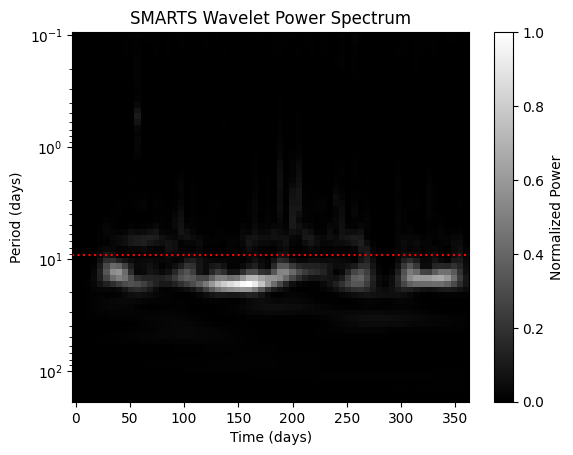

In [6]:
# Plot an example WPS
wl, p = train_dataset[8]

wldata = wl.squeeze().numpy()

plt.figure()
plt.pcolormesh(
    np.linspace(0, 360, len(wldata)),  # time baseline is about a year
    np.geomspace(0.1, 180, len(wldata)),  # period axis goes from 0.1 to 180
    wldata,
    shading="nearest",
    cmap="binary_r"
)
plt.yscale("log")
plt.xlabel("Time (days)")
plt.ylabel("Period (days)")
plt.gca().invert_yaxis()
plt.title("SMARTS Wavelet Power Spectrum")
plt.colorbar(label="Normalized Power")

# Plot the actual rotation period of the simulated star
plt.axhline(180*p.numpy().item(), color="r", linestyle=":");

This is an example of a WPS. For sinusoidal signals, there is a horizontal band of power at the dominant frequency. This example star has an equatorial rotation period of about 9 days, but the dominant frequency from the power spectrum is about 10.5 days. This is due to surface differential rotation, where spots emerge at higher latitudes that rotate more slowly than the equator.

This panel (without the axes or colorbar) is what the CNN will be trained on.

## 2. Build the CNN

We will build a CNN that takes 2D input (the WPS) and predicts two values: the stellar rotation period and its corresponding uncertainty. The CNN has the following aspects:
- Three 2D convolution layers for feature extraction
- ReLU activation
- 1D max pooling in the time axis, for dimensionality reduction without losing frequency resolution.
- Dropout to build redundancy and avoid overfitting
- Softplus output for regression

The CNN also has a configurable number of feature extractors (also called "kernels" or "filters"), which is set by the `c` parameter. It defaults to `[8, 16, 32]`, so that each successive convolution layer increases in depth by a factor of 2. You might also try `[16, 32, 64]` or `[32, 64, 128]` to see whether more feature extractors improve the performance.

In [7]:
class ConvNet(nn.Module):
    """
    A relatively simple 2D Convolutional Neural Network with a configurable
    number of trainable convolution kernels.
    
    Parameters
    ----------
    c (list of ints, [8, 16, 32]): List of convolutional kernel depths.
    
    k (int or list of ints, 3): Convolutional kernel widths. If an int is
        passed, it will be multiplied into a list of length `len(c)`.
    """
    def __init__(self, c=[8, 16, 32], k=3):
        if isinstance(k, int):
            k = [k]*len(c)
            
        n_nodes = (64 - (sum(k) - len(k))) * c[-1]

        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(  1,  c[0], k[0], 1)  # 62 x 20
        self.conv2 = nn.Conv2d(c[0], c[1], k[1], 1)  # 60 x 6 
        self.conv3 = nn.Conv2d(c[1], c[2], k[2], 1)  # 58 x 1
        self.fc1 = nn.Linear(n_nodes, 256)  # 58 x 32 = 1856
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 2)
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout2d(0.1)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, (1, 3))
        x = self.dropout2(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, (1, 3))
        x = self.dropout2(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, (1, x.shape[-1]))
        x = self.dropout2(x)

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout1(x)
        output = F.softplus(self.fc3(x))
        return output

Here we will also define our loss function. A typical loss function for regression is the mean squared error (MSE). However, MSE doesn't allow for the prediction of uncertainties. Alternative loss functions that allow the prediction of uncertainties include the Laplacian and Gaussian Negative Log-Likelihoods (NLL). Gaussian NLL is analogous to MSE, while Laplacian NLL is analogous to median absolute error, which is less biased by outliers and more accurately predicts values near the edges of the training distribution. For these reasons, we will use the Laplacian NLL, which has the form

$L = \frac{1}{2b} \exp(\frac{-|x - \mu|}{b})$,

where $\mu$ is the mean, and $b$ is related to the variance $\sigma^2$ by $\sigma^2 = 2 b^2$.

The negative log-likelihood is then

$-\log L = \frac{|x - \mu|}{b} + \ln(2b)$.

You may find that other loss functions work better for your use case. We recommend trying several.

In [8]:
def laplacian_nll(y_pred, y_true, k=1):
    """
    Compute Negative Log Likelihood for Laplacian Output Layer. This loss function
    lets the CNN predict a value with a related uncertainty.

    Args:
        y_pred: Nx2k matrix of parameters. Each row parametrizes
                k Laplacian distributions, each with (mean, std).
        y_true: Nxk matrix of (data) target values.
    """
    means = y_pred[:, :k]
    sigmas = y_pred[:, k:]

    # convert from sigma to b
    b = sigmas / np.sqrt(2) 

    # compute NLL
    nll = torch.abs(means - y_true)/b + torch.log(2*b)
    return nll

def gaussian_nll(y_pred, y_true, k=1):
    """
    Compute Negative Log Likelihood for Gaussian Output Layer. This loss function
    lets the CNN predict a value with a related uncertainty.

    Args:
        y_pred: Nx2k matrix of parameters. Each row parametrizes
                k Laplacian distributions, each with (mean, std).
        y_true: Nxk matrix of (data) target values.
    """
    means = y_pred[:, :k]
    sigmas = y_pred[:, k:] 

    # compute NLL
    nll = ((means - y_true)/sigmas)**2 + torch.log(2*np.pi*sigmas)
    return nll/2

# Set the chosen loss function here
loss_function = laplacian_nll

## 3. Define training, validation, and evaluation functions

We train the CNN using the Adam optimizer, which uses adaptive learning rates (LR) to train the network. To vary the LR, we use a plateau scheduler (`ReduceLROnPlateau`), which reduces the LR when the loss plateaus. This enables the CNN parameters to find local minima more easily, rather than take large steps over them.

Finally, we will also use an early stopping criterion. This means that if the validation loss plateaus or increases for a certain number of epochs, training stops early, and the best fit CNN values are saved.

In [9]:
def train(model, train_loader, valid_loader, num_epochs=100, early_stopping_patience=10, device=torch.device("cpu")):
    """Train the neural network for all desired epochs.
    """
    optimizer = optim.Adam(model.parameters(), lr=5e-5)
    # Set learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7, patience=3)

    # Set up training loop
    train_p_loss = []
    val_p_loss = []
    min_loss = 100
    early_stopping_count = 0
    best_epoch = 0

    for epoch in range(1, num_epochs + 1):
        # Compute a single epoch of training
        p_loss = train_epoch(model, train_loader, optimizer, epoch, device=device)
        train_p_loss.append(p_loss)
        p_loss = evaluate(model, valid_loader)
        val_p_loss.append(p_loss)
        total_loss = p_loss
        scheduler.step(total_loss)  # step learning rate scheduler

        # if new fit is better than the previous best fit, update best fit weights
        if total_loss < min_loss:
            min_loss = total_loss
            early_stopping_count = 0
            best_epoch = epoch
            best_weights = deepcopy(model.state_dict())
        # otherwise, if loss is not getting better, count down to stopping criterion
        else:
            early_stopping_count += 1
            print(f"Early Stopping Count: {early_stopping_count}")
            if early_stopping_count == early_stopping_patience:
                print(f"Early Stopping. Best Epoch: {best_epoch} with loss {min_loss:.4f}.")
                with open("best_epoch.txt", "w") as f:
                    print(best_epoch, file=f)
                break    

    # save and return the best fit weights
    torch.save(best_weights, f"model.pt")
    return best_weights, train_p_loss, val_p_loss


def train_epoch(model, train_loader, optimizer, epoch, device=torch.device("cpu")):
    """Train the network for a single epoch.
    """
    model.train()  # Set the model to training mode
    period_losses = []
    # iterate over data batches
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device, dtype=torch.float), target.to(device, dtype=torch.float)
        optimizer.zero_grad()  # Clear the gradient
        output = model(data)  # Make predictions
        loss = loss_function(output, target).mean()
        loss.backward()  # Gradient computation        
        optimizer.step()  # Perform a single optimization step
        period_losses.append(loss.item())

        # print progress every few batches
        if (batch_idx*len(data)) % 500 == 0:
            print("Epoch: {:3d} [{:5d}/{:5d} ({:3.0f}%)] Training Loss: {:9.6f}".format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), period_losses[-1]))
            
    # return the mean loss value
    return np.mean(period_losses)


def evaluate(model, test_loader, verbose=True, device=torch.device("cpu"), return_predictions=False):
    """
    Evaluate network on validation or test data and compute loss.
    This is like "train" except the weights are not updated.
    """
    model.eval()  # Set the model to inference mode
    test_p_loss = 0
    targets = []
    preds = []
    with torch.no_grad():  # For the inference step, gradient is not computed
        for data, target in test_loader:
            data, target = data.to(device, dtype=torch.float), target.to(device, dtype=torch.float)
            output = model(data)
            targets.extend(target.cpu().numpy())
            preds.extend(output.cpu().numpy())
            test_p_loss += loss_function(output, target).sum()
            
    test_p_loss /= len(test_loader.dataset)

    if verbose:
        print(f"Test loss: {test_p_loss:.4f}")
    if return_predictions:
        return test_p_loss, np.squeeze(preds), np.squeeze(targets)
    return test_p_loss

## 4. Train the CNN on SMARTS data

In [10]:
# Initialize CNN
model = ConvNet(c=filters)

# Train CNN
weights, train_p_loss, val_p_loss = train(model, train_loader, valid_loader,
    early_stopping_patience=10, num_epochs=num_epochs)

Epoch:   1 [    0/ 8000 (  0%)] Training Loss:  0.575162


Epoch:   1 [  500/ 8000 (  6%)] Training Loss:  0.610845


Epoch:   1 [ 1000/ 8000 ( 12%)] Training Loss:  0.444789


Epoch:   1 [ 1500/ 8000 ( 19%)] Training Loss:  0.438787


Epoch:   1 [ 2000/ 8000 ( 25%)] Training Loss:  0.445467


Epoch:   1 [ 2500/ 8000 ( 31%)] Training Loss:  0.331284


Epoch:   1 [ 3000/ 8000 ( 38%)] Training Loss:  0.381290


Epoch:   1 [ 3500/ 8000 ( 44%)] Training Loss:  0.339752


Epoch:   1 [ 4000/ 8000 ( 50%)] Training Loss:  0.182749


Epoch:   1 [ 4500/ 8000 ( 56%)] Training Loss:  0.371045


Epoch:   1 [ 5000/ 8000 ( 62%)] Training Loss:  0.353536


Epoch:   1 [ 5500/ 8000 ( 69%)] Training Loss:  0.345336


Epoch:   1 [ 6000/ 8000 ( 75%)] Training Loss:  0.232175


Epoch:   1 [ 6500/ 8000 ( 81%)] Training Loss:  0.366428


Epoch:   1 [ 7000/ 8000 ( 88%)] Training Loss:  0.284384


Epoch:   1 [ 7500/ 8000 ( 94%)] Training Loss:  0.492535


Test loss: 0.3045
Epoch:   2 [    0/ 8000 (  0%)] Training Loss:  0.296180


Epoch:   2 [  500/ 8000 (  6%)] Training Loss:  0.475287


Epoch:   2 [ 1000/ 8000 ( 12%)] Training Loss:  0.272705


Epoch:   2 [ 1500/ 8000 ( 19%)] Training Loss:  0.258431


Epoch:   2 [ 2000/ 8000 ( 25%)] Training Loss:  0.378992


Epoch:   2 [ 2500/ 8000 ( 31%)] Training Loss:  0.208311


Epoch:   2 [ 3000/ 8000 ( 38%)] Training Loss:  0.322407


Epoch:   2 [ 3500/ 8000 ( 44%)] Training Loss:  0.342891


Epoch:   2 [ 4000/ 8000 ( 50%)] Training Loss:  0.210131


Epoch:   2 [ 4500/ 8000 ( 56%)] Training Loss:  0.364870


Epoch:   2 [ 5000/ 8000 ( 62%)] Training Loss:  0.311264


Epoch:   2 [ 5500/ 8000 ( 69%)] Training Loss:  0.309026


Epoch:   2 [ 6000/ 8000 ( 75%)] Training Loss:  0.200377


Epoch:   2 [ 6500/ 8000 ( 81%)] Training Loss:  0.325533


Epoch:   2 [ 7000/ 8000 ( 88%)] Training Loss:  0.286022


Epoch:   2 [ 7500/ 8000 ( 94%)] Training Loss:  0.442966


Test loss: 0.2618
Epoch:   3 [    0/ 8000 (  0%)] Training Loss:  0.262717


Epoch:   3 [  500/ 8000 (  6%)] Training Loss:  0.406286


Epoch:   3 [ 1000/ 8000 ( 12%)] Training Loss:  0.233385


Epoch:   3 [ 1500/ 8000 ( 19%)] Training Loss:  0.192313


Epoch:   3 [ 2000/ 8000 ( 25%)] Training Loss:  0.341165


Epoch:   3 [ 2500/ 8000 ( 31%)] Training Loss:  0.140508


Epoch:   3 [ 3000/ 8000 ( 38%)] Training Loss:  0.297368


Epoch:   3 [ 3500/ 8000 ( 44%)] Training Loss:  0.227784


Epoch:   3 [ 4000/ 8000 ( 50%)] Training Loss:  0.118470


Epoch:   3 [ 4500/ 8000 ( 56%)] Training Loss:  0.333037


Epoch:   3 [ 5000/ 8000 ( 62%)] Training Loss:  0.290194


Epoch:   3 [ 5500/ 8000 ( 69%)] Training Loss:  0.271156


Epoch:   3 [ 6000/ 8000 ( 75%)] Training Loss:  0.082075


Epoch:   3 [ 6500/ 8000 ( 81%)] Training Loss:  0.270208


Epoch:   3 [ 7000/ 8000 ( 88%)] Training Loss:  0.225345


Epoch:   3 [ 7500/ 8000 ( 94%)] Training Loss:  0.344451


Test loss: 0.2340
Epoch:   4 [    0/ 8000 (  0%)] Training Loss:  0.256205


Epoch:   4 [  500/ 8000 (  6%)] Training Loss:  0.364359


Epoch:   4 [ 1000/ 8000 ( 12%)] Training Loss:  0.295996


Epoch:   4 [ 1500/ 8000 ( 19%)] Training Loss:  0.120267


Epoch:   4 [ 2000/ 8000 ( 25%)] Training Loss:  0.334042


Epoch:   4 [ 2500/ 8000 ( 31%)] Training Loss:  0.173124


Epoch:   4 [ 3000/ 8000 ( 38%)] Training Loss:  0.248428


Epoch:   4 [ 3500/ 8000 ( 44%)] Training Loss:  0.194836


Epoch:   4 [ 4000/ 8000 ( 50%)] Training Loss:  0.108231


Epoch:   4 [ 4500/ 8000 ( 56%)] Training Loss:  0.266289


Epoch:   4 [ 5000/ 8000 ( 62%)] Training Loss:  0.287311


Epoch:   4 [ 5500/ 8000 ( 69%)] Training Loss:  0.249780


Epoch:   4 [ 6000/ 8000 ( 75%)] Training Loss:  0.114030


Epoch:   4 [ 6500/ 8000 ( 81%)] Training Loss:  0.301799


Epoch:   4 [ 7000/ 8000 ( 88%)] Training Loss:  0.326320


Epoch:   4 [ 7500/ 8000 ( 94%)] Training Loss:  0.388101


Test loss: 0.2333
Epoch:   5 [    0/ 8000 (  0%)] Training Loss:  0.337691


Epoch:   5 [  500/ 8000 (  6%)] Training Loss:  0.407707


Epoch:   5 [ 1000/ 8000 ( 12%)] Training Loss:  0.257284


Epoch:   5 [ 1500/ 8000 ( 19%)] Training Loss:  0.170404


Epoch:   5 [ 2000/ 8000 ( 25%)] Training Loss:  0.310470


Epoch:   5 [ 2500/ 8000 ( 31%)] Training Loss:  0.141226


Epoch:   5 [ 3000/ 8000 ( 38%)] Training Loss:  0.292000


Epoch:   5 [ 3500/ 8000 ( 44%)] Training Loss:  0.241041


Epoch:   5 [ 4000/ 8000 ( 50%)] Training Loss:  0.113812


Epoch:   5 [ 4500/ 8000 ( 56%)] Training Loss:  0.301326


Epoch:   5 [ 5000/ 8000 ( 62%)] Training Loss:  0.303455


Epoch:   5 [ 5500/ 8000 ( 69%)] Training Loss:  0.275898


Epoch:   5 [ 6000/ 8000 ( 75%)] Training Loss:  0.061796


Epoch:   5 [ 6500/ 8000 ( 81%)] Training Loss:  0.254562


Epoch:   5 [ 7000/ 8000 ( 88%)] Training Loss:  0.298238


Epoch:   5 [ 7500/ 8000 ( 94%)] Training Loss:  0.362178


Test loss: 0.2272
Epoch:   6 [    0/ 8000 (  0%)] Training Loss:  0.254310


Epoch:   6 [  500/ 8000 (  6%)] Training Loss:  0.322689


Epoch:   6 [ 1000/ 8000 ( 12%)] Training Loss:  0.234108


Epoch:   6 [ 1500/ 8000 ( 19%)] Training Loss:  0.153513


Epoch:   6 [ 2000/ 8000 ( 25%)] Training Loss:  0.338179


Epoch:   6 [ 2500/ 8000 ( 31%)] Training Loss:  0.162006


Epoch:   6 [ 3000/ 8000 ( 38%)] Training Loss:  0.292955


Epoch:   6 [ 3500/ 8000 ( 44%)] Training Loss:  0.220800


Epoch:   6 [ 4000/ 8000 ( 50%)] Training Loss:  0.143798


Epoch:   6 [ 4500/ 8000 ( 56%)] Training Loss:  0.279670


Epoch:   6 [ 5000/ 8000 ( 62%)] Training Loss:  0.265485


Epoch:   6 [ 5500/ 8000 ( 69%)] Training Loss:  0.299336


Epoch:   6 [ 6000/ 8000 ( 75%)] Training Loss:  0.132134


Epoch:   6 [ 6500/ 8000 ( 81%)] Training Loss:  0.273439


Epoch:   6 [ 7000/ 8000 ( 88%)] Training Loss:  0.279075


Epoch:   6 [ 7500/ 8000 ( 94%)] Training Loss:  0.332744


Test loss: 0.2222
Epoch:   7 [    0/ 8000 (  0%)] Training Loss:  0.250884


Epoch:   7 [  500/ 8000 (  6%)] Training Loss:  0.374180


Epoch:   7 [ 1000/ 8000 ( 12%)] Training Loss:  0.238376


Epoch:   7 [ 1500/ 8000 ( 19%)] Training Loss:  0.135620


Epoch:   7 [ 2000/ 8000 ( 25%)] Training Loss:  0.341522


Epoch:   7 [ 2500/ 8000 ( 31%)] Training Loss:  0.148944


Epoch:   7 [ 3000/ 8000 ( 38%)] Training Loss:  0.313608


Epoch:   7 [ 3500/ 8000 ( 44%)] Training Loss:  0.176567


Epoch:   7 [ 4000/ 8000 ( 50%)] Training Loss:  0.061224


Epoch:   7 [ 4500/ 8000 ( 56%)] Training Loss:  0.252087


Epoch:   7 [ 5000/ 8000 ( 62%)] Training Loss:  0.311205


Epoch:   7 [ 5500/ 8000 ( 69%)] Training Loss:  0.315710


Epoch:   7 [ 6000/ 8000 ( 75%)] Training Loss:  0.145026


Epoch:   7 [ 6500/ 8000 ( 81%)] Training Loss:  0.289482


Epoch:   7 [ 7000/ 8000 ( 88%)] Training Loss:  0.231719


Epoch:   7 [ 7500/ 8000 ( 94%)] Training Loss:  0.327896


Test loss: 0.2167
Epoch:   8 [    0/ 8000 (  0%)] Training Loss:  0.271672


Epoch:   8 [  500/ 8000 (  6%)] Training Loss:  0.407888


Epoch:   8 [ 1000/ 8000 ( 12%)] Training Loss:  0.212384


Epoch:   8 [ 1500/ 8000 ( 19%)] Training Loss:  0.149499


Epoch:   8 [ 2000/ 8000 ( 25%)] Training Loss:  0.286266


Epoch:   8 [ 2500/ 8000 ( 31%)] Training Loss:  0.172137


Epoch:   8 [ 3000/ 8000 ( 38%)] Training Loss:  0.313013


Epoch:   8 [ 3500/ 8000 ( 44%)] Training Loss:  0.244127


Epoch:   8 [ 4000/ 8000 ( 50%)] Training Loss:  0.124600


Epoch:   8 [ 4500/ 8000 ( 56%)] Training Loss:  0.258178


Epoch:   8 [ 5000/ 8000 ( 62%)] Training Loss:  0.303822


Epoch:   8 [ 5500/ 8000 ( 69%)] Training Loss:  0.312904


Epoch:   8 [ 6000/ 8000 ( 75%)] Training Loss:  0.085169


Epoch:   8 [ 6500/ 8000 ( 81%)] Training Loss:  0.264361


Epoch:   8 [ 7000/ 8000 ( 88%)] Training Loss:  0.249699


Epoch:   8 [ 7500/ 8000 ( 94%)] Training Loss:  0.362730


Test loss: 0.2181
Early Stopping Count: 1
Epoch:   9 [    0/ 8000 (  0%)] Training Loss:  0.262929


Epoch:   9 [  500/ 8000 (  6%)] Training Loss:  0.368385


Epoch:   9 [ 1000/ 8000 ( 12%)] Training Loss:  0.223393


Epoch:   9 [ 1500/ 8000 ( 19%)] Training Loss:  0.103982


Epoch:   9 [ 2000/ 8000 ( 25%)] Training Loss:  0.336602


Epoch:   9 [ 2500/ 8000 ( 31%)] Training Loss:  0.136145


Epoch:   9 [ 3000/ 8000 ( 38%)] Training Loss:  0.299505


Epoch:   9 [ 3500/ 8000 ( 44%)] Training Loss:  0.237103


Epoch:   9 [ 4000/ 8000 ( 50%)] Training Loss:  0.119137


Epoch:   9 [ 4500/ 8000 ( 56%)] Training Loss:  0.243878


Epoch:   9 [ 5000/ 8000 ( 62%)] Training Loss:  0.300902


Epoch:   9 [ 5500/ 8000 ( 69%)] Training Loss:  0.283236


Epoch:   9 [ 6000/ 8000 ( 75%)] Training Loss:  0.142143


Epoch:   9 [ 6500/ 8000 ( 81%)] Training Loss:  0.270774


Epoch:   9 [ 7000/ 8000 ( 88%)] Training Loss:  0.264012


Epoch:   9 [ 7500/ 8000 ( 94%)] Training Loss:  0.333261


Test loss: 0.2070
Epoch:  10 [    0/ 8000 (  0%)] Training Loss:  0.225312


Epoch:  10 [  500/ 8000 (  6%)] Training Loss:  0.338756


Epoch:  10 [ 1000/ 8000 ( 12%)] Training Loss:  0.206627


Epoch:  10 [ 1500/ 8000 ( 19%)] Training Loss:  0.179548


Epoch:  10 [ 2000/ 8000 ( 25%)] Training Loss:  0.304030


Epoch:  10 [ 2500/ 8000 ( 31%)] Training Loss:  0.128224


Epoch:  10 [ 3000/ 8000 ( 38%)] Training Loss:  0.369728


Epoch:  10 [ 3500/ 8000 ( 44%)] Training Loss:  0.206604


Epoch:  10 [ 4000/ 8000 ( 50%)] Training Loss:  0.132868


Epoch:  10 [ 4500/ 8000 ( 56%)] Training Loss:  0.292926


Epoch:  10 [ 5000/ 8000 ( 62%)] Training Loss:  0.248278


Epoch:  10 [ 5500/ 8000 ( 69%)] Training Loss:  0.305074


Epoch:  10 [ 6000/ 8000 ( 75%)] Training Loss:  0.061336


Epoch:  10 [ 6500/ 8000 ( 81%)] Training Loss:  0.236473


Epoch:  10 [ 7000/ 8000 ( 88%)] Training Loss:  0.264069


Epoch:  10 [ 7500/ 8000 ( 94%)] Training Loss:  0.325789


Test loss: 0.2012
Epoch:  11 [    0/ 8000 (  0%)] Training Loss:  0.286728


Epoch:  11 [  500/ 8000 (  6%)] Training Loss:  0.338227


Epoch:  11 [ 1000/ 8000 ( 12%)] Training Loss:  0.197625


Epoch:  11 [ 1500/ 8000 ( 19%)] Training Loss:  0.114818


Epoch:  11 [ 2000/ 8000 ( 25%)] Training Loss:  0.258796


Epoch:  11 [ 2500/ 8000 ( 31%)] Training Loss:  0.092410


Epoch:  11 [ 3000/ 8000 ( 38%)] Training Loss:  0.344620


Epoch:  11 [ 3500/ 8000 ( 44%)] Training Loss:  0.236683


Epoch:  11 [ 4000/ 8000 ( 50%)] Training Loss:  0.045492


Epoch:  11 [ 4500/ 8000 ( 56%)] Training Loss:  0.298449


Epoch:  11 [ 5000/ 8000 ( 62%)] Training Loss:  0.324902


Epoch:  11 [ 5500/ 8000 ( 69%)] Training Loss:  0.268598


Epoch:  11 [ 6000/ 8000 ( 75%)] Training Loss:  0.055375


Epoch:  11 [ 6500/ 8000 ( 81%)] Training Loss:  0.257181


Epoch:  11 [ 7000/ 8000 ( 88%)] Training Loss:  0.237169


Epoch:  11 [ 7500/ 8000 ( 94%)] Training Loss:  0.282529


Test loss: 0.1945
Epoch:  12 [    0/ 8000 (  0%)] Training Loss:  0.241708


Epoch:  12 [  500/ 8000 (  6%)] Training Loss:  0.373011


Epoch:  12 [ 1000/ 8000 ( 12%)] Training Loss:  0.153525


Epoch:  12 [ 1500/ 8000 ( 19%)] Training Loss:  0.079620


Epoch:  12 [ 2000/ 8000 ( 25%)] Training Loss:  0.313065


Epoch:  12 [ 2500/ 8000 ( 31%)] Training Loss:  0.077472


Epoch:  12 [ 3000/ 8000 ( 38%)] Training Loss:  0.322882


Epoch:  12 [ 3500/ 8000 ( 44%)] Training Loss:  0.211778


Epoch:  12 [ 4000/ 8000 ( 50%)] Training Loss:  0.038527


Epoch:  12 [ 4500/ 8000 ( 56%)] Training Loss:  0.264031


Epoch:  12 [ 5000/ 8000 ( 62%)] Training Loss:  0.299187


Epoch:  12 [ 5500/ 8000 ( 69%)] Training Loss:  0.315940


Epoch:  12 [ 6000/ 8000 ( 75%)] Training Loss:  0.038248


Epoch:  12 [ 6500/ 8000 ( 81%)] Training Loss:  0.242998


Epoch:  12 [ 7000/ 8000 ( 88%)] Training Loss:  0.244771


Epoch:  12 [ 7500/ 8000 ( 94%)] Training Loss:  0.269640


Test loss: 0.1830
Epoch:  13 [    0/ 8000 (  0%)] Training Loss:  0.186747


Epoch:  13 [  500/ 8000 (  6%)] Training Loss:  0.328821


Epoch:  13 [ 1000/ 8000 ( 12%)] Training Loss:  0.153123


Epoch:  13 [ 1500/ 8000 ( 19%)] Training Loss:  0.108869


Epoch:  13 [ 2000/ 8000 ( 25%)] Training Loss:  0.257631


Epoch:  13 [ 2500/ 8000 ( 31%)] Training Loss:  0.141544


Epoch:  13 [ 3000/ 8000 ( 38%)] Training Loss:  0.260475


Epoch:  13 [ 3500/ 8000 ( 44%)] Training Loss:  0.171047


Epoch:  13 [ 4000/ 8000 ( 50%)] Training Loss:  0.015325


Epoch:  13 [ 4500/ 8000 ( 56%)] Training Loss:  0.340913


Epoch:  13 [ 5000/ 8000 ( 62%)] Training Loss:  0.221867


Epoch:  13 [ 5500/ 8000 ( 69%)] Training Loss:  0.302691


Epoch:  13 [ 6000/ 8000 ( 75%)] Training Loss:  0.039959


Epoch:  13 [ 6500/ 8000 ( 81%)] Training Loss:  0.223356


Epoch:  13 [ 7000/ 8000 ( 88%)] Training Loss:  0.178487


Epoch:  13 [ 7500/ 8000 ( 94%)] Training Loss:  0.207351


Test loss: 0.1710
Epoch:  14 [    0/ 8000 (  0%)] Training Loss:  0.184514


Epoch:  14 [  500/ 8000 (  6%)] Training Loss:  0.320723


Epoch:  14 [ 1000/ 8000 ( 12%)] Training Loss:  0.145266


Epoch:  14 [ 1500/ 8000 ( 19%)] Training Loss:  0.098035


Epoch:  14 [ 2000/ 8000 ( 25%)] Training Loss:  0.219390


Epoch:  14 [ 2500/ 8000 ( 31%)] Training Loss:  0.043216


Epoch:  14 [ 3000/ 8000 ( 38%)] Training Loss:  0.258917


Epoch:  14 [ 3500/ 8000 ( 44%)] Training Loss:  0.177623


Epoch:  14 [ 4000/ 8000 ( 50%)] Training Loss:  0.018683


Epoch:  14 [ 4500/ 8000 ( 56%)] Training Loss:  0.321617


Epoch:  14 [ 5000/ 8000 ( 62%)] Training Loss:  0.298061


Epoch:  14 [ 5500/ 8000 ( 69%)] Training Loss:  0.221937


Epoch:  14 [ 6000/ 8000 ( 75%)] Training Loss:  0.022262


Epoch:  14 [ 6500/ 8000 ( 81%)] Training Loss:  0.252438


Epoch:  14 [ 7000/ 8000 ( 88%)] Training Loss:  0.232324


Epoch:  14 [ 7500/ 8000 ( 94%)] Training Loss:  0.227102


Test loss: 0.1636
Epoch:  15 [    0/ 8000 (  0%)] Training Loss:  0.220585


Epoch:  15 [  500/ 8000 (  6%)] Training Loss:  0.308488


Epoch:  15 [ 1000/ 8000 ( 12%)] Training Loss:  0.170905


Epoch:  15 [ 1500/ 8000 ( 19%)] Training Loss:  0.106915


Epoch:  15 [ 2000/ 8000 ( 25%)] Training Loss:  0.224367


Epoch:  15 [ 2500/ 8000 ( 31%)] Training Loss:  0.120642


Epoch:  15 [ 3000/ 8000 ( 38%)] Training Loss:  0.250475


Epoch:  15 [ 3500/ 8000 ( 44%)] Training Loss:  0.170506


Epoch:  15 [ 4000/ 8000 ( 50%)] Training Loss:  0.023384


Epoch:  15 [ 4500/ 8000 ( 56%)] Training Loss:  0.263970


Epoch:  15 [ 5000/ 8000 ( 62%)] Training Loss:  0.274798


Epoch:  15 [ 5500/ 8000 ( 69%)] Training Loss:  0.236568


Epoch:  15 [ 6000/ 8000 ( 75%)] Training Loss:  0.003615


Epoch:  15 [ 6500/ 8000 ( 81%)] Training Loss:  0.208258


Epoch:  15 [ 7000/ 8000 ( 88%)] Training Loss:  0.232558


Epoch:  15 [ 7500/ 8000 ( 94%)] Training Loss:  0.232522


Test loss: 0.1546
Epoch:  16 [    0/ 8000 (  0%)] Training Loss:  0.267334


Epoch:  16 [  500/ 8000 (  6%)] Training Loss:  0.313345


Epoch:  16 [ 1000/ 8000 ( 12%)] Training Loss:  0.155407


Epoch:  16 [ 1500/ 8000 ( 19%)] Training Loss:  0.088002


Epoch:  16 [ 2000/ 8000 ( 25%)] Training Loss:  0.168831


Epoch:  16 [ 2500/ 8000 ( 31%)] Training Loss:  0.074557


Epoch:  16 [ 3000/ 8000 ( 38%)] Training Loss:  0.264558


Epoch:  16 [ 3500/ 8000 ( 44%)] Training Loss:  0.135820


Epoch:  16 [ 4000/ 8000 ( 50%)] Training Loss:  0.029167


Epoch:  16 [ 4500/ 8000 ( 56%)] Training Loss:  0.288098


Epoch:  16 [ 5000/ 8000 ( 62%)] Training Loss:  0.258994


Epoch:  16 [ 5500/ 8000 ( 69%)] Training Loss:  0.280464


Epoch:  16 [ 6000/ 8000 ( 75%)] Training Loss:  0.068615


Epoch:  16 [ 6500/ 8000 ( 81%)] Training Loss:  0.211652


Epoch:  16 [ 7000/ 8000 ( 88%)] Training Loss:  0.208525


Epoch:  16 [ 7500/ 8000 ( 94%)] Training Loss:  0.274456


Test loss: 0.1454
Epoch:  17 [    0/ 8000 (  0%)] Training Loss:  0.252409


Epoch:  17 [  500/ 8000 (  6%)] Training Loss:  0.346439


Epoch:  17 [ 1000/ 8000 ( 12%)] Training Loss:  0.082718


Epoch:  17 [ 1500/ 8000 ( 19%)] Training Loss:  0.016846


Epoch:  17 [ 2000/ 8000 ( 25%)] Training Loss:  0.223700


Epoch:  17 [ 2500/ 8000 ( 31%)] Training Loss:  0.058964


Epoch:  17 [ 3000/ 8000 ( 38%)] Training Loss:  0.246388


Epoch:  17 [ 3500/ 8000 ( 44%)] Training Loss:  0.185188


Epoch:  17 [ 4000/ 8000 ( 50%)] Training Loss:  0.003403


Epoch:  17 [ 4500/ 8000 ( 56%)] Training Loss:  0.316264


Epoch:  17 [ 5000/ 8000 ( 62%)] Training Loss:  0.316291


Epoch:  17 [ 5500/ 8000 ( 69%)] Training Loss:  0.273281


Epoch:  17 [ 6000/ 8000 ( 75%)] Training Loss: -0.008495


Epoch:  17 [ 6500/ 8000 ( 81%)] Training Loss:  0.204137


Epoch:  17 [ 7000/ 8000 ( 88%)] Training Loss:  0.183708


Epoch:  17 [ 7500/ 8000 ( 94%)] Training Loss:  0.204157


Test loss: 0.1356
Epoch:  18 [    0/ 8000 (  0%)] Training Loss:  0.214294


Epoch:  18 [  500/ 8000 (  6%)] Training Loss:  0.264618


Epoch:  18 [ 1000/ 8000 ( 12%)] Training Loss:  0.118414


Epoch:  18 [ 1500/ 8000 ( 19%)] Training Loss:  0.028611


Epoch:  18 [ 2000/ 8000 ( 25%)] Training Loss:  0.226510


Epoch:  18 [ 2500/ 8000 ( 31%)] Training Loss:  0.065674


Epoch:  18 [ 3000/ 8000 ( 38%)] Training Loss:  0.198359


Epoch:  18 [ 3500/ 8000 ( 44%)] Training Loss:  0.114771


Epoch:  18 [ 4000/ 8000 ( 50%)] Training Loss:  0.000107


Epoch:  18 [ 4500/ 8000 ( 56%)] Training Loss:  0.331509


Epoch:  18 [ 5000/ 8000 ( 62%)] Training Loss:  0.289340


Epoch:  18 [ 5500/ 8000 ( 69%)] Training Loss:  0.275291


Epoch:  18 [ 6000/ 8000 ( 75%)] Training Loss: -0.024939


Epoch:  18 [ 6500/ 8000 ( 81%)] Training Loss:  0.160678


Epoch:  18 [ 7000/ 8000 ( 88%)] Training Loss:  0.228051


Epoch:  18 [ 7500/ 8000 ( 94%)] Training Loss:  0.181976


Test loss: 0.1210
Epoch:  19 [    0/ 8000 (  0%)] Training Loss:  0.347059


Epoch:  19 [  500/ 8000 (  6%)] Training Loss:  0.312782


Epoch:  19 [ 1000/ 8000 ( 12%)] Training Loss:  0.053068


Epoch:  19 [ 1500/ 8000 ( 19%)] Training Loss:  0.050921


Epoch:  19 [ 2000/ 8000 ( 25%)] Training Loss:  0.097798


Epoch:  19 [ 2500/ 8000 ( 31%)] Training Loss:  0.116656


Epoch:  19 [ 3000/ 8000 ( 38%)] Training Loss:  0.170591


Epoch:  19 [ 3500/ 8000 ( 44%)] Training Loss:  0.171495


Epoch:  19 [ 4000/ 8000 ( 50%)] Training Loss: -0.028286


Epoch:  19 [ 4500/ 8000 ( 56%)] Training Loss:  0.268572


Epoch:  19 [ 5000/ 8000 ( 62%)] Training Loss:  0.315440


Epoch:  19 [ 5500/ 8000 ( 69%)] Training Loss:  0.179195


Epoch:  19 [ 6000/ 8000 ( 75%)] Training Loss: -0.035189


Epoch:  19 [ 6500/ 8000 ( 81%)] Training Loss:  0.169484


Epoch:  19 [ 7000/ 8000 ( 88%)] Training Loss:  0.163280


Epoch:  19 [ 7500/ 8000 ( 94%)] Training Loss:  0.118794


Test loss: 0.1101
Epoch:  20 [    0/ 8000 (  0%)] Training Loss:  0.242851


Epoch:  20 [  500/ 8000 (  6%)] Training Loss:  0.256537


Epoch:  20 [ 1000/ 8000 ( 12%)] Training Loss:  0.111477


Epoch:  20 [ 1500/ 8000 ( 19%)] Training Loss:  0.021284


Epoch:  20 [ 2000/ 8000 ( 25%)] Training Loss:  0.116904


Epoch:  20 [ 2500/ 8000 ( 31%)] Training Loss:  0.081162


Epoch:  20 [ 3000/ 8000 ( 38%)] Training Loss:  0.311807


Epoch:  20 [ 3500/ 8000 ( 44%)] Training Loss:  0.119477


Epoch:  20 [ 4000/ 8000 ( 50%)] Training Loss: -0.040711


Epoch:  20 [ 4500/ 8000 ( 56%)] Training Loss:  0.269962


Epoch:  20 [ 5000/ 8000 ( 62%)] Training Loss:  0.333823


Epoch:  20 [ 5500/ 8000 ( 69%)] Training Loss:  0.193534


Epoch:  20 [ 6000/ 8000 ( 75%)] Training Loss: -0.118823


Epoch:  20 [ 6500/ 8000 ( 81%)] Training Loss:  0.208642


Epoch:  20 [ 7000/ 8000 ( 88%)] Training Loss:  0.161853


Epoch:  20 [ 7500/ 8000 ( 94%)] Training Loss:  0.138950


Test loss: 0.1066


Now that the CNN is trained, we should take a look at the "learning curves," or the loss over time.

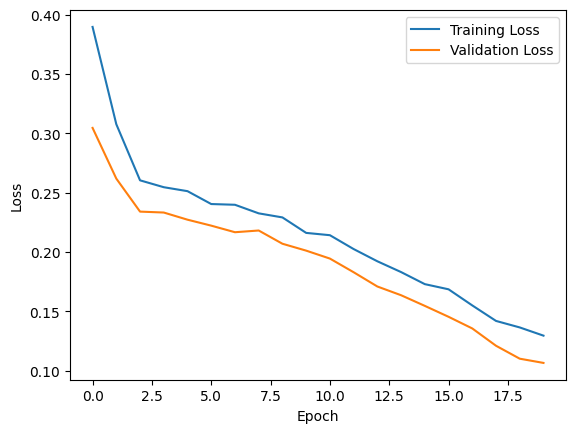

In [11]:
plt.figure()
plt.plot(train_p_loss, label="Training Loss")
plt.plot(val_p_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend();

For this exercise, we only trained on a small subset of the training data, and for a limited number of training epochs. This means that the CNN hasn't yet reached a plateau, and it's not fully trained. You will see better performance by training for more epochs (until the loss values plateau), which you can configure back in [Section 0](#0.configure-training-run) by changing `num_epochs`. You can also train on a larger piece of the training data by configuring `max_n` in the same cell. 

## 5. Test the CNN performance

Now we use the trained CNN to predict stellar rotation periods from a held-out test set, and compare the predictions to the true values. 

Since we're only training over a small fraction of the training set in this tutorial, we don't expect the predictions to match the true values. You will see better performance by training on a larger piece (or all) of the training set, or training for more epochs, by configuring `max_n` or `num_epochs` back in [Section 0](#0.configure-training-run).

In [12]:
# evaluate CNN to infer rotation periods
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=50)
test_loss, preds, trues = evaluate(model, test_loader, verbose=True, return_predictions=True)

Test loss: 0.0655


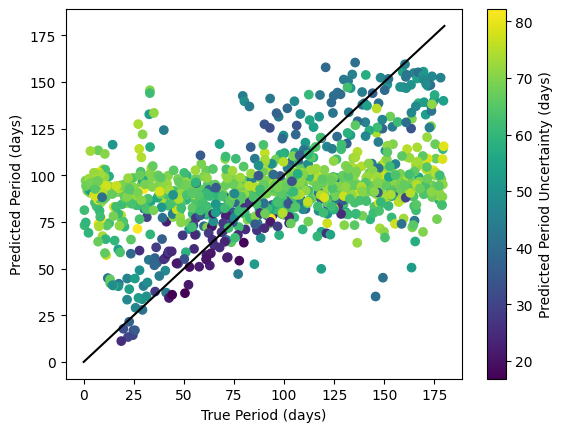

In [13]:
# compare the CNN predictions to the true values
%matplotlib inline

true_periods = trues*test_dataset.pmax
pred_periods = preds[:, 0]*test_dataset.pmax
pred_sigma = preds[:, 1]*test_dataset.pmax

plt.scatter(true_periods, pred_periods, c=pred_sigma)
plt.plot([0, 180], [0, 180], "k")
plt.xlabel("True Period (days)")
plt.ylabel("Predicted Period (days)")
plt.colorbar(label="Predicted Period Uncertainty (days)");

Most of the data are predicted to have the median period of 90 days, which is the best guess when the CNN doesn't know better. We also predicted the uncertainty in the period, so let's see what that looks like.

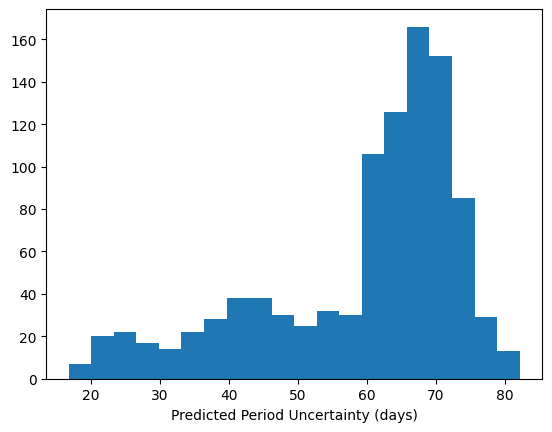

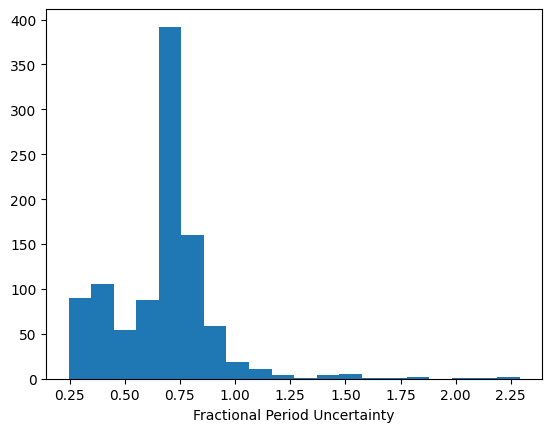

In [14]:
sigmas = preds[:, 1]*test_dataset.pmax
frac = sigmas/pred_periods

plt.figure()
plt.hist(sigmas, bins=20)
plt.xlabel("Predicted Period Uncertainty (days)")

plt.figure()
plt.hist(frac, bins=20)
plt.xlabel("Fractional Period Uncertainty");

We can start to see a dip forming at sigma/period ~ 0.5 in the second plot (this dip will become more pronounced for longer training runs), so let's use that to filter the results, weeding out "bad" predictions.

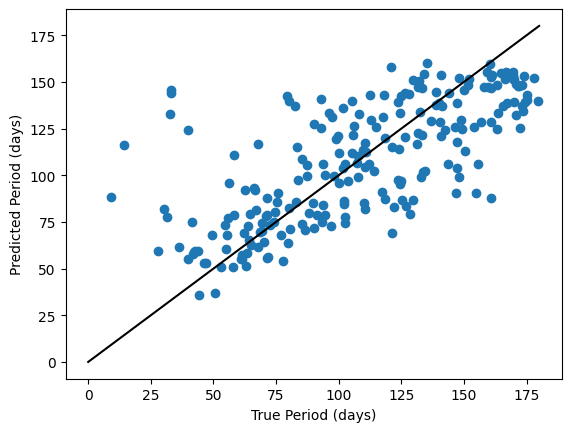

In [15]:
true_filtered = true_periods[frac < 0.5]
pred_filtered = pred_periods[frac < 0.5]
plt.scatter(true_filtered, pred_filtered)
plt.plot([0, 180], [0, 180], "k")
plt.xlabel("True Period (days)")
plt.ylabel("Predicted Period (days)");

With the "bad" predictions filtered out, the predictions look much better, even after only 20 epochs. Remember that the uncertainty is predicted from the quality of the data, so this kind of cut can be applied to predictions on real data as well. 

While our loss function can serve as a metric of accuracy, we might also be interested in more classical accuracy metrics to measure the performance of the CNN. As an example, let's take a look at the root-mean-squared (RMS) error.

In [16]:
def rms_error(true, pred):
    return np.sqrt(np.mean((true - pred)**2))

print(f"Unfiltered prediction count: {len(pred_periods)}\n"
      f"RMS error: {rms_error(true_periods, pred_periods):.2f} days\n\n"
      f"Filtered prediction count:   {len(pred_filtered)}\n"
      f"RMS error: {rms_error(true_filtered, pred_filtered):.2f} days.")

Unfiltered prediction count: 1000
RMS error: 45.67 days

Filtered prediction count:   223
RMS error: 29.18 days.


When the predictions are filtered, we retain only a fraction of the test data, but the accuracy improves significantly. Note that

- Filtering by predicted uncertainty improves the accuracy. This implies that the predicted uncertainty is a useful estimator of the true credibility of CNN predictions.
- While only a fraction of the test set is left after filtering, remember that we trained for only 20 epochs, and on a subset of the training data. Doing a full run will improve both the accuracy of predictions *and* the number of "good" predictions.

## Summary

CNNs are useful machine learning models that can leverage spatially correlated information in images and image-like data. CNNs trained on simulated light curve wavelet transforms make reasonable predictions of the rotation periods of TESS stars despite the complicated orbit-related systematics present in the light curves.

In this tutorial, we
1. downloaded and preprocessed training data from MAST,
2. built a CNN using `pytorch`,
3. defined training, validation, and evaluation functions,
4. trained the CNN, and
5. analyzed the CNN performance on held-out test data.

We explored various machine learning and astrophysics concepts, including
- stellar rotation with TESS light curves,
- continuous wavelet transforms, and
- specialized loss functions to predict values with uncertainty.

## Next Steps

Now that we've run the base case, try the following exercises:
- train on a larger fraction of the training data by increasing `max_n`,
- train for more epochs by increasing `num_epochs`,
- use different train/validation/test ratios by modifying `split`,
- use larger convolution filter depths by changing `filters`,
- use Gaussian NLL loss to train the CNN.

See how any of these choices might affect the CNN performance.

## References

- [_Recovery of TESS Stellar Rotation Periods Using Deep Learning_ (Claytor et al. 2022)](https://ui.adsabs.harvard.edu/abs/2022ApJ...927..219C/abstract)
- [_TESS Stellar Rotation up to 80 Days in the Southern Continuous Viewing Zone_ (Claytor et al. 2024)](https://ui.adsabs.harvard.edu/abs/2024ApJ...962...47C/abstract)
- [_A Practical Guide to Wavelet Analysis_ (Torrence & Compo 1998)](https://ui.adsabs.harvard.edu/abs/1998BAMS...79...61T/abstract)
- [Stellar Magnetism, Activity, and Rotation with Time Series (SMARTS)](https://archive.stsci.edu/hlsp/smarts)